## Set GPU

In [2]:
import torch
if torch.cuda.is_available():
    device = 'cuda'
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    device = 'cpu'
print(f'{device=}')

device='cpu'


## Scipy example

In this section we show an example of bivariate cubic spline interpolation using scipy.interpolate.RectBivariateSpline

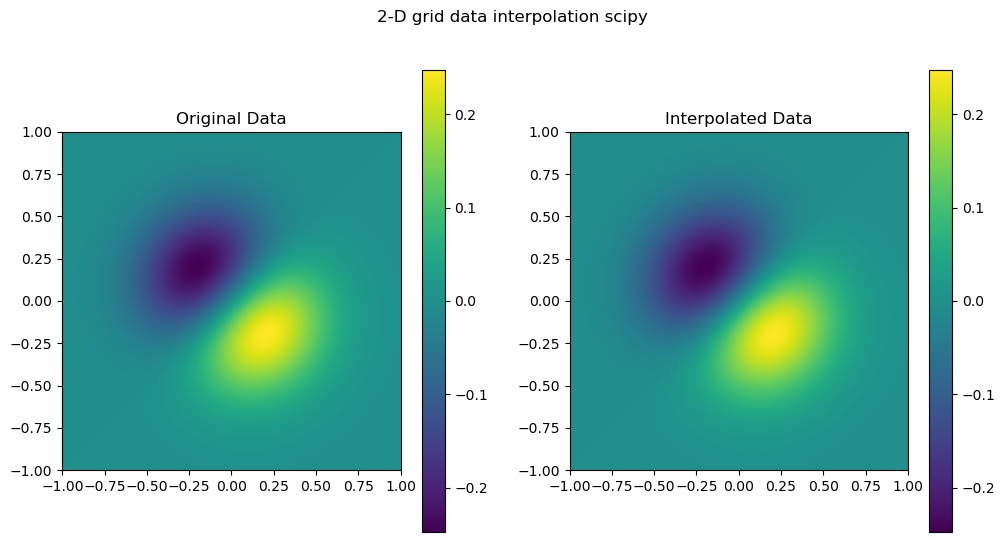

In [2]:
import numpy as np
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as plt

# Generate data
x = np.linspace(-1, 1, 180)
y = np.linspace(-1, 1, 180)
x_grid, y_grid = np.meshgrid(x, y)
z = (x_grid + y_grid) * np.exp(-6.0 * (x_grid ** 2 + y_grid ** 2))

# Create RectBivariateSpline
f = RectBivariateSpline(x, y, z)

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot original data
plt.subplot(1, 2, 1)
im = plt.imshow(z, extent=(x[0], x[-1], y[0], y[-1]))
plt.colorbar(im)
plt.title('Original Data')

# Interpolate onto a new grid
xnew = np.linspace(-1, 1, 400)
ynew = np.linspace(-1, 1, 400)
xnew_grid, ynew_grid = np.meshgrid(xnew, ynew)
znew = f(xnew, ynew)

# Plot interpolated data
plt.subplot(1, 2, 2)
im = plt.imshow(znew, extent=(xnew[0], xnew[-1], ynew[0], ynew[-1]))
plt.colorbar(im)
plt.title('Interpolated Data')

plt.suptitle('2-D grid data interpolation scipy')
plt.show()

## CPU for loop implementation

In this section we show the same example covered int he Scipy example section this time using a custom implemented bivariate cabuic natural spline based in pytorch.

This is a first implementation of the code, highly unoptimized, that makes use of for loops to showcase the algorithm for the computation of the Spline. For further referneces to the maths behind it, visit 
- https://en.wikipedia.org/wiki/De_Boor%27s_algorithm

The Example includes the display of the knots and the basis functions used to compute the interpolating spline, a time benchmark, and a comparison with torch.nn.functional bicubic inteprolation

In [75]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
import torch.nn.functional as F

def generate_natural_knots(x, k):
    start=time.time()
    n = x.shape[0]
    t = torch.zeros(n + 2 * k, device=x.device)
    t[:k] = x[0]
    t[k:-k] = x
    t[-k:] = x[-1]
    end=time.time()
    print(f'Time for knot generation: {end-start}s')
    return t

def bspline_basis_natural(x, k, t):
    start=time.time()
    n = x.shape[0]
    m = t.shape[0] - k - 1

    b = torch.zeros((n, m, k + 1), device=x.device)

    # Initialize zeroth degree basis functions
    for j in range(m):
        b[:, j, 0] = ((t[j] <= x) & (x < t[j + 1])).float()

    # Handle boundary conditions at the first and last knot
    b[:, 0, 0] = torch.where(x < t[1], torch.ones_like(x), b[:, 0, 0])
    b[:, -1, 0] = torch.where(x >= t[-2], torch.ones_like(x), b[:, -1, 0])

    # Recursive definition of B-spline basis functions
    for d in range(1, k + 1):
        for j in range(m): 
                    
            left_num = x - t[j]
            left_den = t[j + d] - t[j]
            right_num = t[j + d + 1] - x
            right_den = t[j + d + 1] - t[j + 1]

            left = torch.zeros_like(left_num)
            right = torch.zeros_like(right_num)
            non_zero_left = left_den > 0
            non_zero_right = right_den > 0

            if non_zero_left.any():
                left[non_zero_left] = (left_num[non_zero_left] / left_den[non_zero_left]) * b[:, j, d - 1][non_zero_left]
            if non_zero_right.any():
                if j<m-1:
                    right[non_zero_right] = (right_num[non_zero_right] / right_den[non_zero_right]) * b[:, j + 1, d - 1][non_zero_right]

            b[:, j, d] = left + right
    
    end=time.time()
    print(f'Time for basis computation: {end-start}s')
    return b[:, :, -1]
    
    

def bivariate_spline_fit_natural(x, y, z, kx, ky, s):
    start=time.time()
    # Generate knots for x and y
    tx = generate_natural_knots(x, kx)
    ty = generate_natural_knots(y, ky)

    # Compute B-spline basis functions for x and y
    bx = bspline_basis_natural(x, kx, tx)
    by = bspline_basis_natural(y, ky, ty)

    # Compute the tensor product of basis functions
    BxBy = torch.einsum('ij,kl->ikjl', bx, by).view(-1, bx.size(1) * by.size(1))

    # Flatten the z values for least-squares fitting
    z_flat = z.view(-1)

    # Add boundary condition constraints
    m = BxBy.size(1)
    I = torch.eye(m, device=BxBy.device)
    C = torch.zeros(m, m, device=BxBy.device)

    # Constrain second derivatives to be zero at boundaries
    for i in range(1, kx):
        C[i, i] = 1
        C[-i, -i] = 1
    for j in range(1, ky):
        C[j * bx.size(1), j * bx.size(1)] = 1
        C[-j * bx.size(1), -j * bx.size(1)] = 1

    B_T_B = BxBy.T @ BxBy + s * (I + C)
    B_T_z = BxBy.T @ z_flat
    end=time.time()
    print(f'B_T_B &B_T_z calculation')
    
    
    
    start=time.time()
    coef = torch.linalg.solve(B_T_B, B_T_z)
    end=time.time()
    print(f'Time for matrix eq resolution: {end-start}s')
    
    return coef, tx, ty

def evaluate_bivariate_spline(x, y, coef, tx, ty, kx, ky):
    start=time.time()
    bx = bspline_basis_natural(x, kx, tx)
    by = bspline_basis_natural(y, ky, ty)
    B = torch.einsum('ij,kl->ikjl', bx, by).view(-1, bx.size(1) * by.size(1))
    z_eval = B @ coef
    end=time.time()
    print(f'Time for spline evaluation: {end-start}s')
    return z_eval

def check_second_derivatives(x, k, knots, coef):
    basis = bspline_basis_natural(x, k, knots)
    second_derivative = torch.zeros_like(x)
    
    for i in range(basis.size(1)):
        second_derivative += coef[i] * basis[:, i]
    
    return second_derivative

def visualize_knots_and_basis(x, k, knots, basis, title):
    plt.figure(figsize=(12, 6))
    
    # Plot knots
    plt.subplot(1, 2, 1)
    plt.plot(knots.cpu(), 'o-', label='Knots')
    plt.title(f'{title} Knots')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    
    # Plot basis functions
    plt.subplot(1, 2, 2)
    for i in range(basis.size(1)):
        plt.plot(x.cpu(), basis[:, i].cpu(), label=f'B{i}')
    plt.title(f'{title} Basis Functions')
    plt.xlabel('x')
    plt.ylabel('Value')
    plt.legend()
    
    plt.show()

def analyze_coefficients(coef):
    plt.figure(figsize=(12, 6))
    plt.plot(coef.cpu(), 'o-')
    plt.title('Spline Coefficients')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

def print_basis_functions(x, k, knots, basis):
    for i in range(basis.size(1)):
        print(f'Basis function B{i}:')
        for j in range(basis.size(0)):
            print(f'    x={x[j].item():.2f}: {basis[j, i].item():.6f}')
        print('')



torch.Size([10, 10])
Time for knot generation: 0.0s
Time for knot generation: 0.0s
Time for basis computation: 0.026903390884399414s
Time for basis computation: 0.021941661834716797s
B_T_B &B_T_z calculation
Time for matrix eq resolution: 0.0s
Debugging Second Derivatives:
Time for knot generation: 0.0s
Time for knot generation: 0.0s
Time for basis computation: 0.03111886978149414s
Time for basis computation: 0.024350404739379883s
Second derivative at the left boundary (x): -1.2276148481760174e-05
Second derivative at the right boundary (x): 0.0
Second derivative at the bottom boundary (y): -1.2276148481760174e-05
Second derivative at the top boundary (y): 0.0
Time for basis computation: 0.03250002861022949s
Time for basis computation: 0.016155242919921875s

Debugging Knots and Basis Functions:
Time for basis computation: 0.001163482666015625s


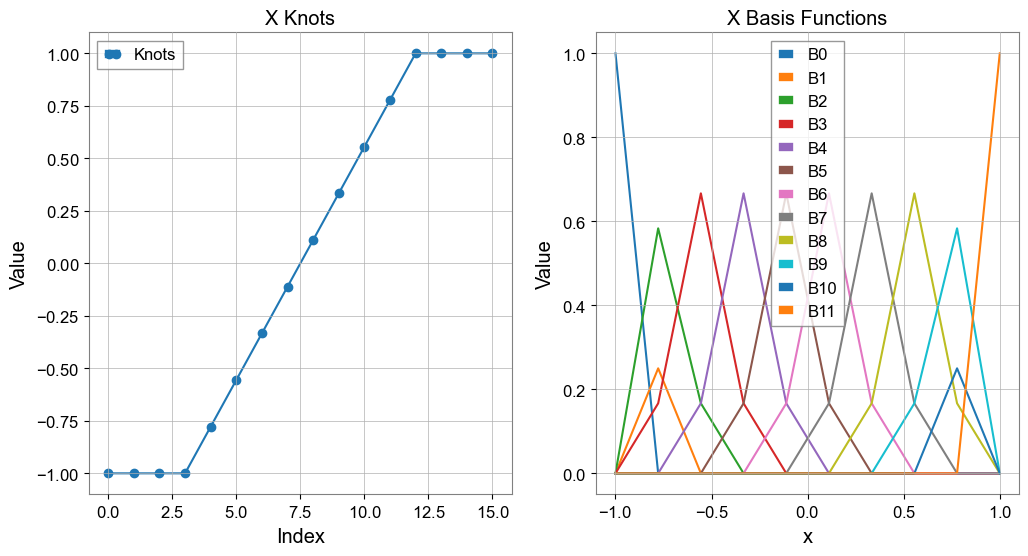

Time for basis computation: 0.01777505874633789s


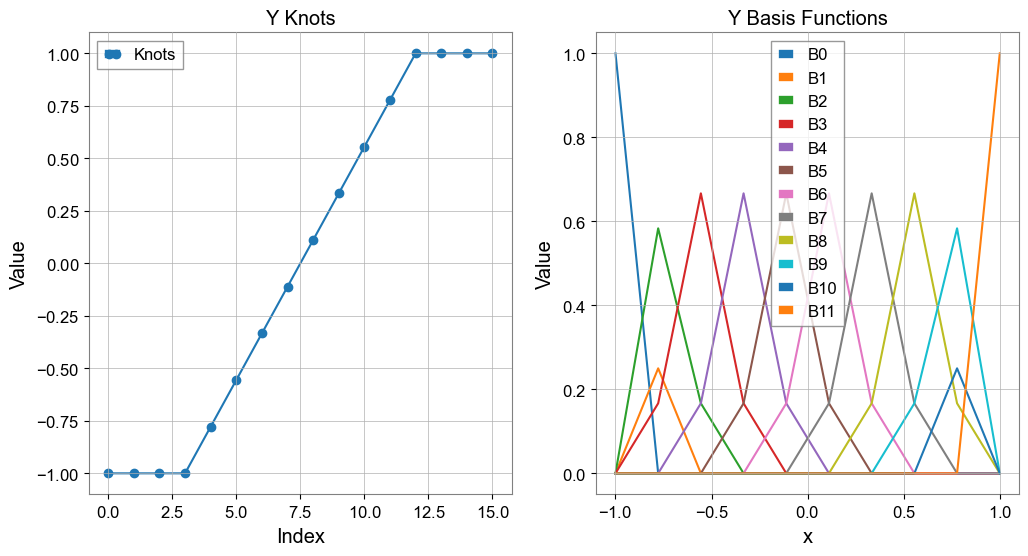


Debugging Coefficients:


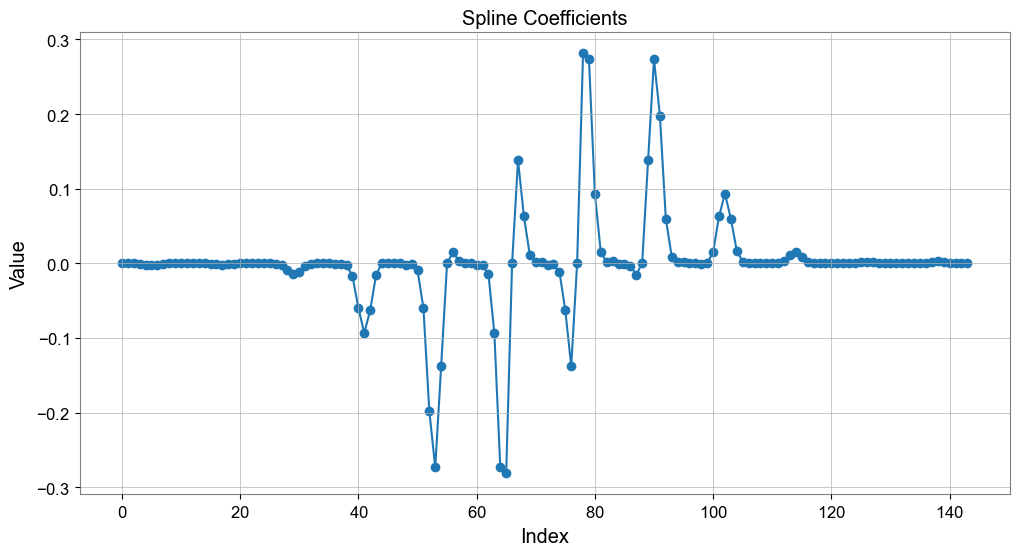

Time for basis computation: 0.016940832138061523s
Time for basis computation: 0.01662731170654297s
Time for spline evaluation: 0.13141870498657227s


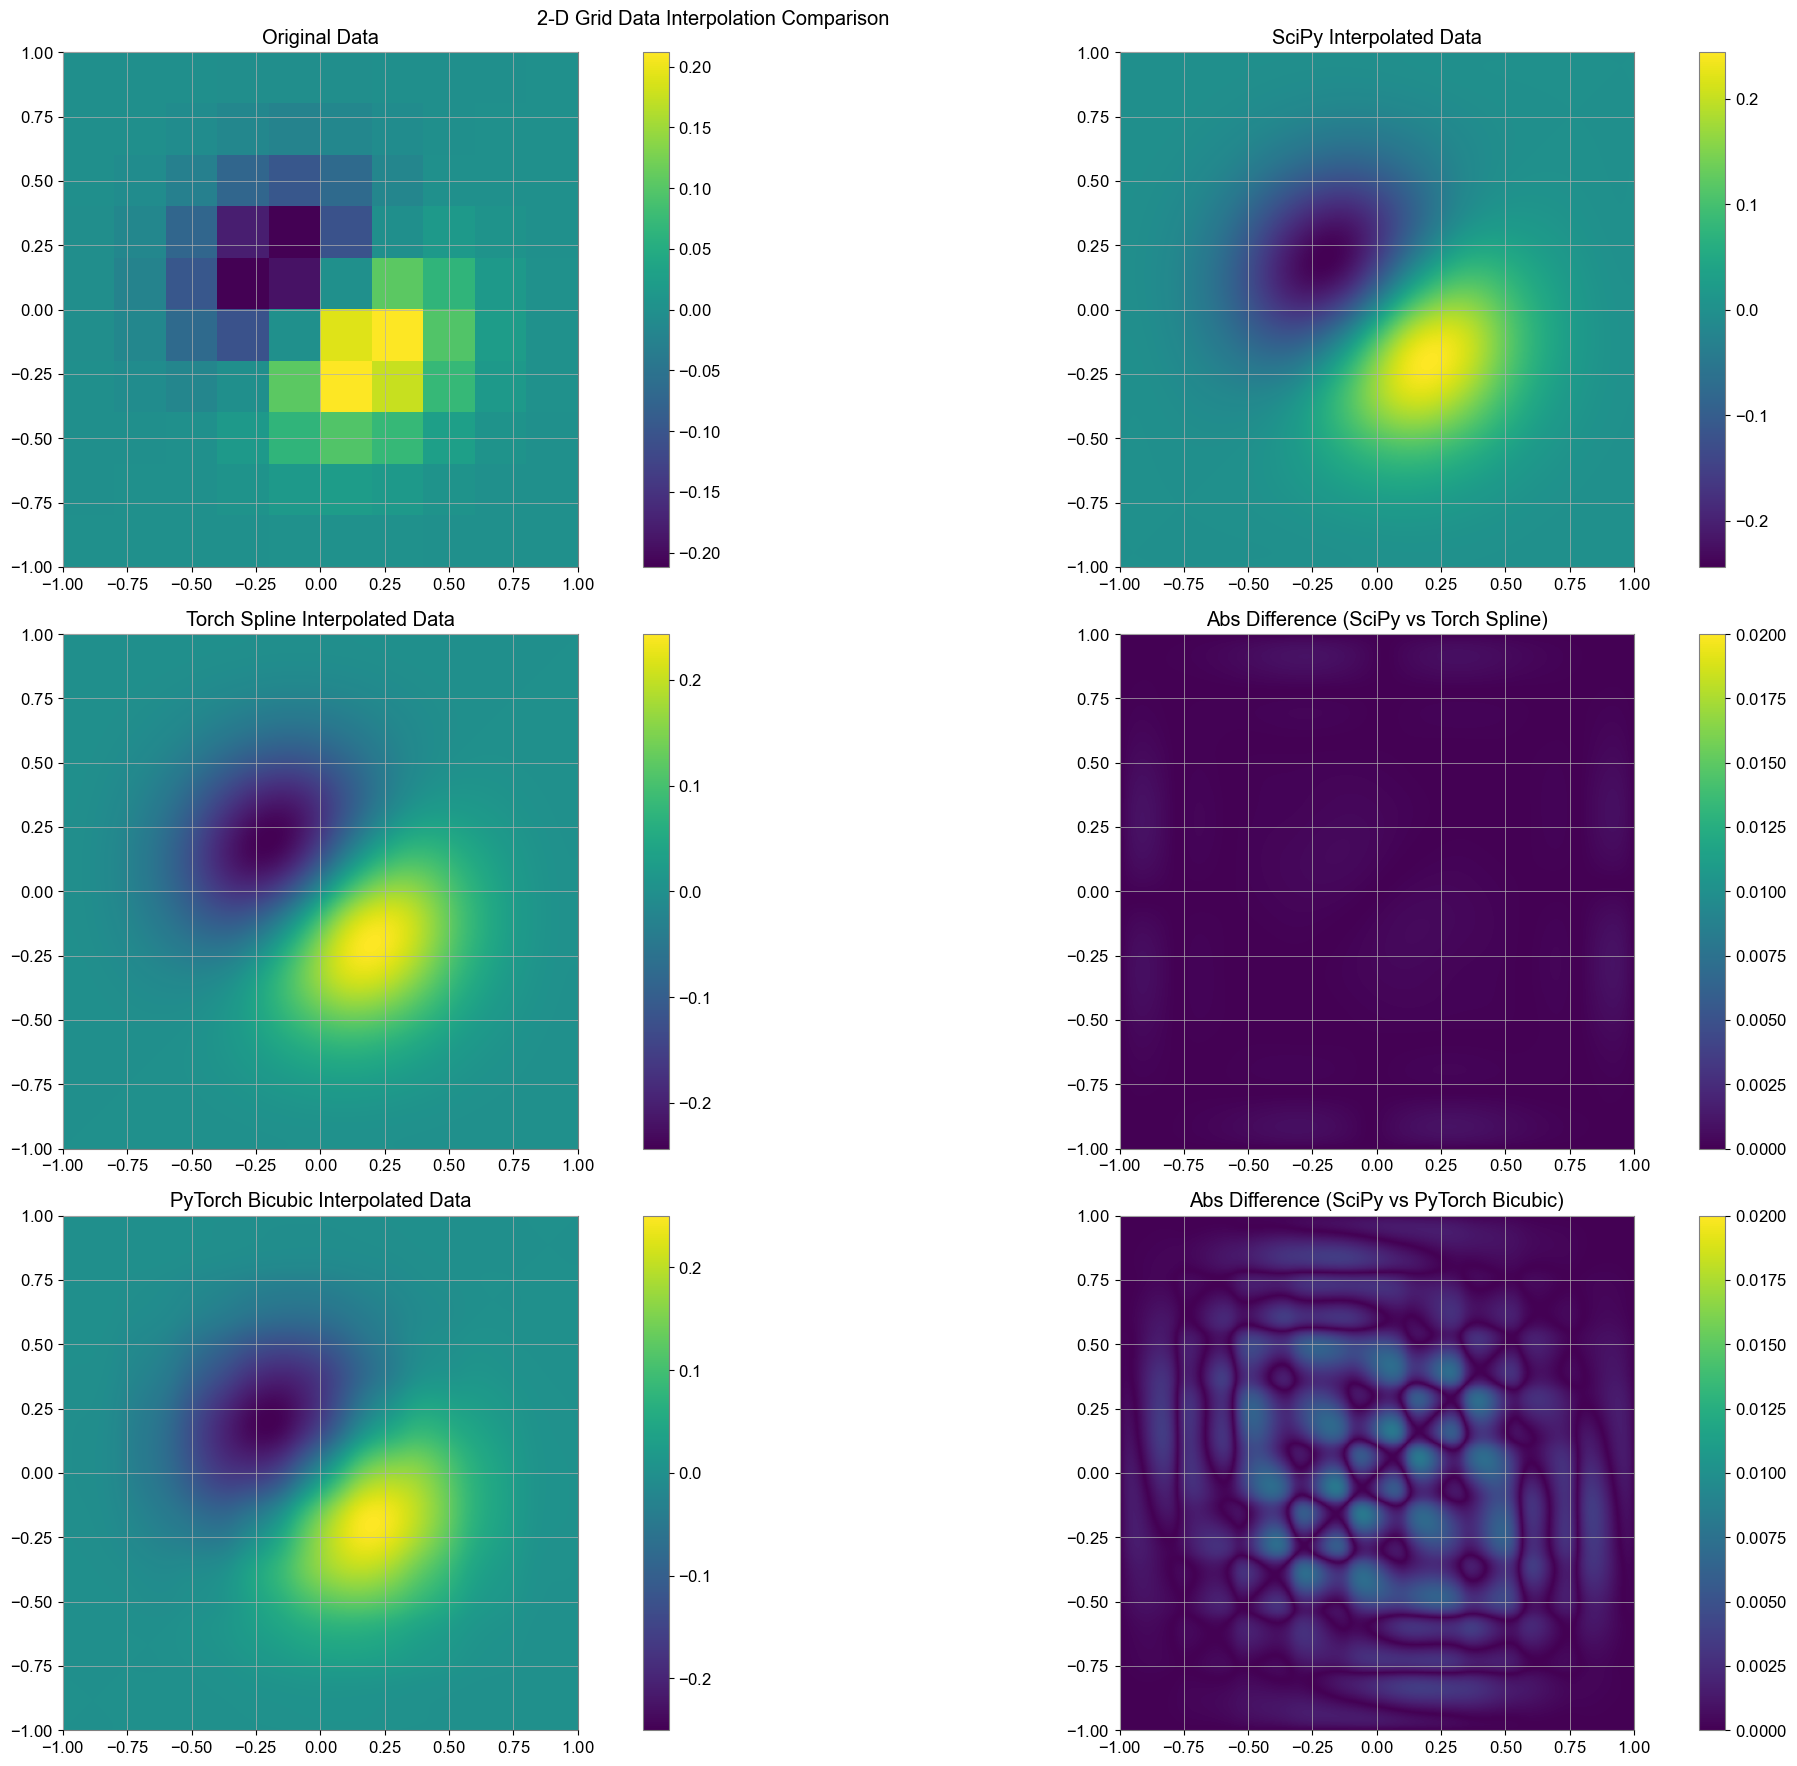

In [76]:
#EXAMPLE USAGE

# Generate data
x = np.linspace(-1, 1, 10)
y = np.linspace(-1, 1, 10)
x_grid, y_grid = np.meshgrid(x, y)
z = (x_grid + y_grid) * np.exp(-6.0 * (x_grid ** 2 + y_grid ** 2))

# Convert numpy arrays to torch tensors
z_torch = torch.from_numpy(z).float()

print(z_torch.shape)

# Fit and evaluate the custom Torch spline interpolation
kx, ky = 3, 3
s = 0.001
coef, tx, ty = bivariate_spline_fit_natural(torch.tensor(x).float(), torch.tensor(y).float(), z_torch, kx, ky,s)

# Debugging steps
print("Debugging Second Derivatives:")
tx = generate_natural_knots(torch.tensor(x).float(), kx)
ty = generate_natural_knots(torch.tensor(y).float(), ky)
second_derivative_x = check_second_derivatives(torch.tensor(x).float(), kx, tx, coef)
second_derivative_y = check_second_derivatives(torch.tensor(y).float(), ky, ty, coef)
print('Second derivative at the left boundary (x):', second_derivative_x[0].item())
print('Second derivative at the right boundary (x):', second_derivative_x[-1].item())
print('Second derivative at the bottom boundary (y):', second_derivative_y[0].item())
print('Second derivative at the top boundary (y):', second_derivative_y[-1].item())

def print_basis_functions(x, k, knots, basis):
    for i in range(basis.size(1)):
        if i>19:
            print(f'Basis function B{i}:')
            for j in range(basis.size(0)):
                print(f'    x={x[j].item():.2f}: {basis[j, i].item():.6f}')
            print('')

#UNCOMMENT TO PRINT BASIs FUNCTIONS!
print_basis_functions(torch.tensor(x).float(), kx, tx, bspline_basis_natural(torch.tensor(x).float(), kx, tx))
print_basis_functions(torch.tensor(y).float(), ky, ty, bspline_basis_natural(torch.tensor(y).float(), ky, ty))


print("\nDebugging Knots and Basis Functions:")
visualize_knots_and_basis(torch.tensor(x).float(), kx, tx, bspline_basis_natural(torch.tensor(x).float(), kx, tx), 'X')
visualize_knots_and_basis(torch.tensor(y).float(), ky, ty, bspline_basis_natural(torch.tensor(y).float(), ky, ty), 'Y')

print("\nDebugging Coefficients:")
analyze_coefficients(coef)

# Evaluate the spline on a grid
x_eval = torch.linspace(-1, 1, 400)
y_eval = torch.linspace(-1, 1, 400)
znew_torch = evaluate_bivariate_spline(x_eval, y_eval, coef, tx, ty, kx, ky).view(400, 400)

# Plotting the results
plt.figure(figsize=(24, 18))

# Plot original data
plt.subplot(3, 2, 1)
im = plt.imshow(z, extent=(-1, 1, -1, 1))
plt.colorbar(im)
plt.title('Original Data')

# Interpolate onto a new grid using SciPy for comparison
f = RectBivariateSpline(x, y, z)
znew_scipy = f(x_eval.numpy(), y_eval.numpy())

# Plot SciPy interpolated data
plt.subplot(3, 2, 2)
im = plt.imshow(znew_scipy, extent=(-1, 1, -1, 1))
plt.colorbar(im)
plt.title('SciPy Interpolated Data')

# Plot Torch spline interpolated data
plt.subplot(3, 2, 3)
im = plt.imshow(znew_torch.detach().numpy(), extent=(-1, 1, -1, 1))
plt.colorbar(im)
plt.title('Torch Spline Interpolated Data')

# Calculate the absolute differences
abs_diff_torch = np.abs(znew_scipy - znew_torch.detach().numpy())

# Plot the absolute difference between SciPy and Torch spline interpolations
plt.subplot(3, 2, 4)
im = plt.imshow(abs_diff_torch, extent=(-1, 1, -1, 1), vmin=0, vmax=0.02)
plt.colorbar(im)
plt.title('Abs Difference (SciPy vs Torch Spline)')

# Perform bicubic interpolation using PyTorch
z_torch_unsqueeze = z_torch.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
znew_bicubic_torch = F.interpolate(z_torch_unsqueeze, size=(400, 400), mode='bicubic', align_corners=True)
znew_bicubic_torch = znew_bicubic_torch.squeeze(0).squeeze(0)  # Remove batch and channel dimensions

# Plot PyTorch bicubic interpolated data
plt.subplot(3, 2, 5)
im = plt.imshow(znew_bicubic_torch.detach().numpy(), extent=(-1, 1, -1, 1))
plt.colorbar(im)
plt.title('PyTorch Bicubic Interpolated Data')

# Calculate the absolute differences
abs_diff_bicubic = np.abs(znew_scipy - znew_bicubic_torch.detach().numpy())

# Plot the absolute difference between SciPy and PyTorch bicubic interpolations
plt.subplot(3, 2, 6)
im = plt.imshow(abs_diff_bicubic, extent=(-1, 1, -1, 1), vmin=0, vmax=0.02)
plt.colorbar(im)
plt.title('Abs Difference (SciPy vs PyTorch Bicubic)')

plt.suptitle('2-D Grid Data Interpolation Comparison')
plt.tight_layout()
plt.show()


## GPU tensorized implementation

In this section we show the same example covered in the Scipy example section this time using a custom implemented bivariate cabuic natural spline based in pytorch.

This second implementation of the code is a bit more optimized as it makes use of tensor operations and allows for the use of GPU. The math behind the algorithm is still the same as the one used in the previous section.

The Example includes the same basis function display, time benchmark and comparison ith standard torch interpolation methods as included in the previous section

In [7]:
import torch
import time

def generate_natural_knots(x, k):
    n = x.shape[0]
    t = torch.zeros(n + 2 * k, device=x.device)
    t[:k] = x[0]
    t[k:-k] = x
    t[-k:] = x[-1]
    return t

def compute_L_R(x, t, d,m, k):
    # Compute the left term L
    left_num = x.unsqueeze(1) - t[:m].unsqueeze(0)
    print(f'{left_num.shape=}')
    left_den = t[d:m+d] - t[:m]
    print(f'{left_den.shape=}')
    L = left_num / left_den.unsqueeze(0)
    
    # Compute the right term R
    right_num = t[d+1:m+d+1] - x.unsqueeze(1)
    print(f'{right_num.shape=}')
    right_den = t[d+1:m+d+1] - t[1:m+1]
    print(f'{right_den.shape=}')
    if d==1:
        print(f'{right_den=}')
        print(f'{left_den=}')
    R = right_num / right_den.unsqueeze(0)
    
    left = torch.zeros_like(left_num)
    right = torch.zeros_like(right_num)
    zero_left = left_den == 0
    zero_right = right_den == 0
    zero_left_stacked = zero_left.tile(x.shape[0], 1)
    zero_right_stacked = zero_right.tile(x.shape[0], 1)
    print(f'{zero_left_stacked.shape=}')
    L[zero_left_stacked]=0
    R[zero_right_stacked]=0
    
    return L, R

def zeroth_order(x,k,t,n,m):
    # Initialize b tensor
    b = torch.zeros((n, m, k + 1), device=x.device)
    
    # Create masks for the conditions
    mask_lower = t[:m+1].unsqueeze(0)[:, :-1] <= x.unsqueeze(1)
    mask_upper = x.unsqueeze(1) < t[:m+1].unsqueeze(0)[:, 1:]

    # Initialize zeroth degree basis functions
    b[:, :, 0] = mask_lower & mask_upper
    
    # Handle boundary conditions at the first and last knot
    b[:, 0, 0] = torch.where(x < t[1], torch.ones_like(x), b[:, 0, 0])
    b[:, -1, 0] = torch.where(x >= t[-2], torch.ones_like(x), b[:, -1, 0])
    return b



def bspline_basis_natural_torch(x, k, t):
    n = x.shape[0]
    m = t.shape[0] - k - 1
    
    #initialise b tensor
    b=zeroth_order(x,k,t,n,m)
    
    # De Boors' recursive computation of bspline functions (Notice: different from  De Boor's Algorithm!! https://en.wikipedia.org/wiki/De_Boor%27s_algorithm)
    for d in range(1, k+1):
        L, R = compute_L_R(x, t, d, m, k)
        print(f'{L.shape=}')
        print(f'{R.shape=}')
        print(f'{(b[:,:,d-1]).shape=}')
        left = L * b[:, :, d-1]

        zeros_tensor = torch.zeros(b.shape[0], 1)
        print(f'{zeros_tensor.shape=}')
        # Concatenate the original tensor with the zeros tensor along the second dimension
        temp_b = torch.cat([b[:,1:,d-1], zeros_tensor], dim=1)
        print(f'{temp_b.shape=}')
    
        right = R * temp_b
        
        b[:, :, d] = left + right
    
    return b[:, :, -1]



def bivariate_spline_fit_natural_torch(x, y, z, kx, ky, s):
    start=time.time()
    # Generate knots for x and y
    tx = generate_natural_knots(x, kx)
    ty = generate_natural_knots(y, ky)

    # Compute B-spline basis functions for x and y
    bx = bspline_basis_natural_torch(x, kx, tx)
    by = bspline_basis_natural_torch(y, ky, ty)

    # Compute the tensor product of basis functions
    BxBy = torch.einsum('ij,kl->ikjl', bx, by).view(-1, bx.size(1) * by.size(1))

    # Flatten the z values for least-squares fitting
    z_flat = z.view(-1)

    # Add boundary condition constraints
    m = BxBy.size(1)
    I = torch.eye(m, device=BxBy.device)
    C = torch.zeros(m, m, device=BxBy.device)

    '''# Constrain second derivatives to be zero at boundaries
    for i in range(1, kx):
        C[i, i] = 1
        C[-i, -i] = 1
    for j in range(1, ky):
        C[j * bx.size(1), j * bx.size(1)] = 1
        C[-j * bx.size(1), -j * bx.size(1)] = 1
    '''
    B_T_B = BxBy.T @ BxBy + s * (I + C)
    B_T_z = BxBy.T @ z_flat
    end=time.time()
    print(f'B_T_B &B_T_z calculation')
    
    
    
    start=time.time()
    coef = torch.linalg.solve(B_T_B, B_T_z)
    end=time.time()
    print(f'Time for matrix eq resolution: {end-start}s')
    
    return coef, tx, ty

def evaluate_bivariate_spline_torch(x, y, coef, tx, ty, kx, ky):
    start=time.time()
    bx = bspline_basis_natural_torch(x, kx, tx)
    by = bspline_basis_natural_torch(y, ky, ty)
    B = torch.einsum('ij,kl->ikjl', bx, by).view(-1, bx.size(1) * by.size(1))
    z_eval = B @ coef
    end=time.time()
    print(f'Time for spline evaluation: {end-start}s')
    return z_eval

def check_second_derivatives(x, k, knots, coef):
    basis = bspline_basis_natural(x, k, knots)
    second_derivative = torch.zeros_like(x)
    
    for i in range(basis.size(1)):
        second_derivative += coef[i] * basis[:, i]
    
    return second_derivative

def visualize_knots_and_basis(x, k, knots, basis, title):
    plt.figure(figsize=(12, 6))
    
    # Plot knots
    plt.subplot(1, 2, 1)
    plt.plot(knots.cpu(), 'o-', label='Knots')
    plt.title(f'{title} Knots')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    
    # Plot basis functions
    plt.subplot(1, 2, 2)
    for i in range(basis.size(1)):
        plt.plot(x.cpu(), basis[:, i].cpu(), label=f'B{i}')
    plt.title(f'{title} Basis Functions')
    plt.xlabel('x')
    plt.ylabel('Value')
    plt.legend()
    
    plt.show()

def analyze_coefficients(coef):
    plt.figure(figsize=(12, 6))
    plt.plot(coef.cpu(), 'o-')
    plt.title('Spline Coefficients')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

def print_basis_functions(x, k, knots, basis):
    for i in range(basis.size(1)):
        print(f'Basis function B{i}:')
        for j in range(basis.size(0)):
            print(f'    x={x[j].item():.2f}: {basis[j, i].item():.6f}')
        print('')





In [ ]:
#TEST

# Example usage
k = 3
x = torch.linspace(-1, 1, 20, dtype=torch.float32)
t = generate_natural_knots(x, k)
start=time.time()
result = bspline_basis_natural_torch(x, k, t)
end=time.time()
print(f' time for bspline basis torch{end-start}s')
start=time.time()
old_result=bspline_basis_natural(x, k, t)
end=time.time()
print(f'time for vanila basis computation {end-start}s')
print(result.shape)  # Should print (20, 22)
print(old_result.shape)  # Should print (20, 22)
#print(old_result)  # B-spline basis functions of degree k evaluated at points x
print(torch.equal(result,old_result))

torch.Size([10, 10])
left_num.shape=torch.Size([10, 12])
left_den.shape=torch.Size([12])
right_num.shape=torch.Size([10, 12])
right_den.shape=torch.Size([12])
right_den=tensor([0.0000, 0.0000, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222,
        0.2222, 0.2222, 0.0000])
left_den=tensor([0.0000, 0.0000, 0.0000, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222,
        0.2222, 0.2222, 0.2222])
zero_left_stacked.shape=torch.Size([10, 12])
L.shape=torch.Size([10, 12])
R.shape=torch.Size([10, 12])
(b[:,:,d-1]).shape=torch.Size([10, 12])
zeros_tensor.shape=torch.Size([10, 1])
temp_b.shape=torch.Size([10, 12])
left_num.shape=torch.Size([10, 12])
left_den.shape=torch.Size([12])
right_num.shape=torch.Size([10, 12])
right_den.shape=torch.Size([12])
zero_left_stacked.shape=torch.Size([10, 12])
L.shape=torch.Size([10, 12])
R.shape=torch.Size([10, 12])
(b[:,:,d-1]).shape=torch.Size([10, 12])
zeros_tensor.shape=torch.Size([10, 1])
temp_b.shape=torch.Size([10, 12])
left_num.shape=torch.Size(

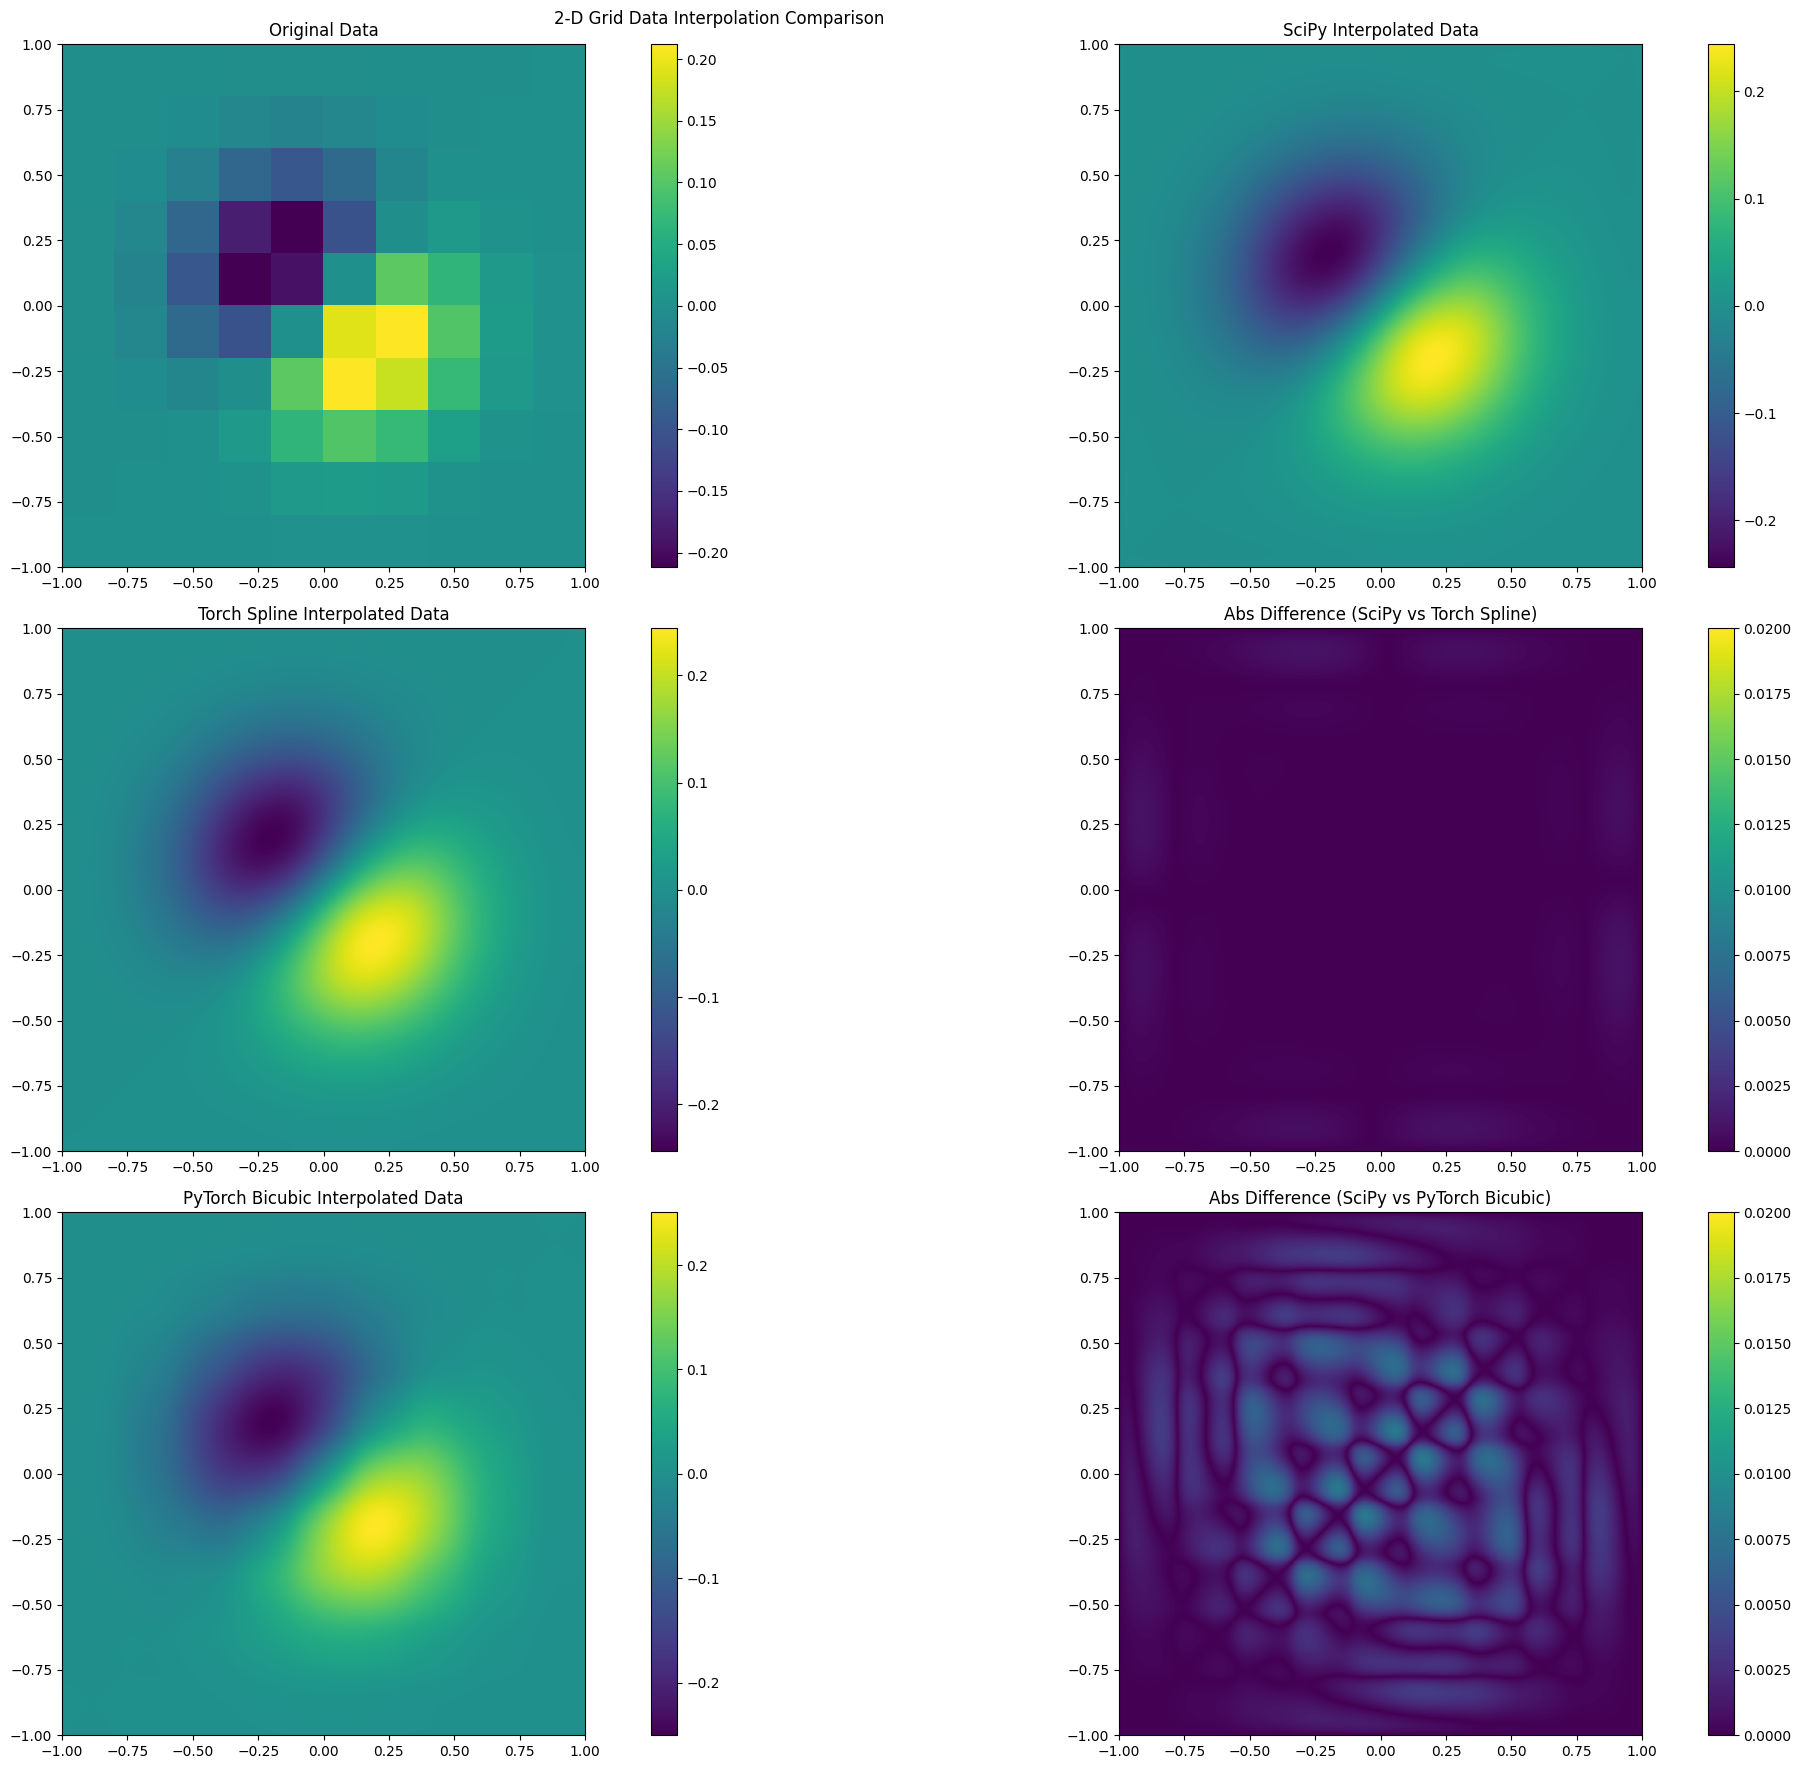

In [9]:
# Generate data
x = np.linspace(-1, 1, 10)
y = np.linspace(-1, 1, 10)
x_grid, y_grid = np.meshgrid(x, y)
z = (x_grid + y_grid) * np.exp(-6.0 * (x_grid ** 2 + y_grid ** 2))

# Convert numpy arrays to torch tensors
z_torch = torch.from_numpy(z).float()

print(z_torch.shape)

# Fit and evaluate the custom Torch spline interpolation
kx, ky = 3, 3
s = 0.00001 #0.001
start=time.time()
coef, tx, ty = bivariate_spline_fit_natural_torch(torch.tensor(x).float(), torch.tensor(y).float(), z_torch, kx, ky,s)
end=time.time()
print(f'TIME FOR SPLINE FIT: {end-start}s')
# Evaluate the spline on a grid

x_eval = torch.linspace(-1, 1, 400)
y_eval = torch.linspace(-1, 1, 400)
start=time.time()
znew_torch = evaluate_bivariate_spline_torch(x_eval, y_eval, coef, tx, ty, kx, ky).view(400, 400)
end=time.time()
print(f'TIME FOR SPLINE EVALUATION: {end-start}s')
      
# Plotting the results
plt.figure(figsize=(24, 18))

# Plot original data
plt.subplot(3, 2, 1)
im = plt.imshow(z, extent=(-1, 1, -1, 1))
plt.colorbar(im)
plt.title('Original Data')

# Interpolate onto a new grid using SciPy for comparison
f = RectBivariateSpline(x, y, z)
znew_scipy = f(x_eval.numpy(), y_eval.numpy())

# Plot SciPy interpolated data
plt.subplot(3, 2, 2)
im = plt.imshow(znew_scipy, extent=(-1, 1, -1, 1))
plt.colorbar(im)
plt.title('SciPy Interpolated Data')

# Plot Torch spline interpolated data
plt.subplot(3, 2, 3)
im = plt.imshow(znew_torch.detach().numpy(), extent=(-1, 1, -1, 1))
plt.colorbar(im)
plt.title('Torch Spline Interpolated Data')


# Calculate the absolute differences
abs_diff_torch = np.abs(znew_scipy - znew_torch.detach().numpy())

# Plot the absolute difference between SciPy and Torch spline interpolations
plt.subplot(3, 2, 4)
im = plt.imshow(abs_diff_torch, extent=(-1, 1, -1, 1), vmin=0, vmax=0.02)
plt.colorbar(im)
plt.title('Abs Difference (SciPy vs Torch Spline)')

# Perform bicubic interpolation using PyTorch

z_torch_unsqueeze = z_torch.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
znew_bicubic_torch = F.interpolate(z_torch_unsqueeze, size=(400, 400), mode='bicubic', align_corners=True)
znew_bicubic_torch = znew_bicubic_torch.squeeze(0).squeeze(0)  # Remove batch and channel dimensions

# Plot PyTorch bicubic interpolated data
plt.subplot(3, 2, 5)
im = plt.imshow(znew_bicubic_torch.detach().numpy(), extent=(-1, 1, -1, 1))
plt.colorbar(im)
plt.title('PyTorch Bicubic Interpolated Data')

# Calculate the absolute differences
abs_diff_bicubic = np.abs(znew_scipy - znew_bicubic_torch.detach().numpy())

# Plot the absolute difference between SciPy and PyTorch bicubic interpolations
plt.subplot(3, 2, 6)

im = plt.imshow(abs_diff_bicubic, extent=(-1, 1, -1, 1), vmin=0, vmax=0.02)
plt.colorbar(im)
plt.title('Abs Difference (SciPy vs PyTorch Bicubic)')

plt.suptitle('2-D Grid Data Interpolation Comparison')
plt.tight_layout()
plt.show()

## FINAL: GPU Tensorized alternative matrix system solution

Same as last section, but more optimized in the solution of the linear system for Control points computation.

This implementation is the same as the one in the package torch_spline_interpolation.py

In [2]:
import numpy as np
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

In [30]:
def generate_natural_knots(x, k):
    n = x.shape[0]
    t = torch.zeros(n + 2 * k)
    t[:k] = x[0]
    t[k:-k] = x
    t[-k:] = x[-1]
    return t

def compute_L_R(x, t, d, m, k):
    left_num = x.unsqueeze(1) - t[:m].unsqueeze(0)
    left_den = t[d:m+d] - t[:m]
    L = left_num / left_den.unsqueeze(0)
    
    right_num = t[d+1:m+d+1] - x.unsqueeze(1)
    right_den = t[d+1:m+d+1] - t[1:m+1]
    R = right_num / right_den.unsqueeze(0)
    
    zero_left = left_den == 0
    zero_right = right_den == 0
    zero_left_stacked = zero_left.tile(x.shape[0], 1)
    zero_right_stacked = zero_right.tile(x.shape[0], 1)
    
    L[zero_left_stacked] = 0
    R[zero_right_stacked] = 0
    
    return L, R

def zeroth_order(x, k, t, n, m):
    b = torch.zeros((n, m, k + 1))
    
    mask_lower = t[:m+1].unsqueeze(0)[:, :-1] <= x.unsqueeze(1)
    mask_upper = x.unsqueeze(1) < t[:m+1].unsqueeze(0)[:, 1:]

    b[:, :, 0] = mask_lower & mask_upper
    
    b[:, 0, 0] = torch.where(x < t[1], torch.ones_like(x), b[:, 0, 0])
    b[:, -1, 0] = torch.where(x >= t[-2], torch.ones_like(x), b[:, -1, 0])
    return b

def bspline_basis_natural_torch(x, k, t):
    n = x.shape[0]
    m = t.shape[0] - k - 1
    
    b = zeroth_order(x, k, t, n, m)
    
    for d in range(1, k + 1):
        L, R = compute_L_R(x, t, d, m, k)
        left = L * b[:, :, d-1]

        zeros_tensor = torch.zeros(b.shape[0], 1)
        temp_b = torch.cat([b[:, 1:, d-1], zeros_tensor], dim=1)
    
        right = R * temp_b
        b[:, :, d] = left + right
    
    return b[:, :, -1]

def bspline_interpolation_2d(x, y, z, degree):
    tx = generate_natural_knots(x, degree)
    ty = generate_natural_knots(y, degree)

    Bx = bspline_basis_natural_torch(x, degree, tx)
    By = bspline_basis_natural_torch(y, degree, ty)


    # Solving for control points in two steps
    #first step
    ByT_By=By.T@By
    ByT_Z_Bx=(By.T@z)@Bx
    E = torch.linalg.solve(ByT_By,ByT_Z_Bx)

    # second step
    C = torch.linalg.solve(Bx.T@Bx, E.T)

    return C, tx, ty

def bspline_evaluate_2d(x, y, tx, ty, C, degree):
    Bx = bspline_basis_natural_torch(x, degree, tx)
    By = bspline_basis_natural_torch(y, degree, ty)

    return torch.einsum('ij,jk,lk->il', Bx, C, By)

# Example usage
x = torch.linspace(-1, 1, 20)
y = torch.linspace(-1, 1, 20)
x_grid, y_grid = torch.meshgrid(x, y, indexing='ij')
z = (x_grid + y_grid) * np.exp(-6.0 * (x_grid ** 2 + y_grid ** 2))
degree = 3

C, tx, ty = bspline_interpolation_2d(x, y, z, degree)

x_eval = torch.linspace(-1, 1, 400)
y_eval = torch.linspace(-1, 1, 500)
Z_new_torch = bspline_evaluate_2d(x_eval, y_eval, tx, ty, C, degree)

print(Z_new_torch.shape)  # Should be (100, 100)


torch.Size([400, 500])


In [15]:
import torch
import numpy as np

def generate_natural_knots(x, k):
    n = x.shape[0]
    t = torch.zeros(n + 2 * k)
    t[:k] = x[0]
    t[k:-k] = x
    t[-k:] = x[-1]
    return t

def compute_L_R(x, t, d, m, k):
    left_num = x.unsqueeze(1) - t[:m].unsqueeze(0)
    left_den = t[d:m+d] - t[:m]
    L = left_num / left_den.unsqueeze(0)
    
    right_num = t[d+1:m+d+1] - x.unsqueeze(1)
    right_den = t[d+1:m+d+1] - t[1:m+1]
    R = right_num / right_den.unsqueeze(0)
    
    zero_left = left_den == 0
    zero_right = right_den == 0
    zero_left_stacked = zero_left.tile(x.shape[0], 1)
    zero_right_stacked = zero_right.tile(x.shape[0], 1)
    
    L[zero_left_stacked] = 0
    R[zero_right_stacked] = 0
    
    return L, R

def zeroth_order(x, k, t, n, m):
    b = torch.zeros((n, m, k + 1))
    
    mask_lower = t[:m+1].unsqueeze(0)[:, :-1] <= x.unsqueeze(1)
    mask_upper = x.unsqueeze(1) < t[:m+1].unsqueeze(0)[:, 1:]

    b[:, :, 0] = mask_lower & mask_upper
    
    b[:, 0, 0] = torch.where(x < t[1], torch.ones_like(x), b[:, 0, 0])
    b[:, -1, 0] = torch.where(x >= t[-2], torch.ones_like(x), b[:, -1, 0])
    return b

def bspline_basis_natural_torch(x, k, t):
    n = x.shape[0]
    m = t.shape[0] - k - 1
    
    b = zeroth_order(x, k, t, n, m)
    
    for d in range(1, k + 1):
        L, R = compute_L_R(x, t, d, m, k)
        left = L * b[:, :, d-1]

        zeros_tensor = torch.zeros(b.shape[0], 1)
        temp_b = torch.cat([b[:, 1:, d-1], zeros_tensor], dim=1)
    
        right = R * temp_b
        b[:, :, d] = left + right
    
    return b[:, :, -1]

def bspline_interpolation_2d(x, y, z, degree, sx=0.00001,sy=0.001):
    tx = generate_natural_knots(x, degree)
    ty = generate_natural_knots(y, degree)

    Bx = bspline_basis_natural_torch(x, degree, tx)
    By = bspline_basis_natural_torch(y, degree, ty)

    # Adding regularization 
    mx = Bx.size(1)
    my = By.size(1)
    Ix = torch.eye(mx, device=Bx.device)
    Iy = torch.eye(my, device=By.device)


    # First step: solve for E in the y-direction
    ByT_By = By.T @ By + sy * Iy
    ByT_Z_Bx = (By.T @ z) @ Bx
    E = torch.linalg.solve(ByT_By, ByT_Z_Bx)

    # Second step: solve for final control points C in the x-direction
    BxT_Bx = Bx.T @ Bx + sx * Ix
    C = torch.linalg.solve(BxT_Bx, E.T).T

    return C, tx, ty

def bspline_evaluate_2d(x, y, tx, ty, C, degree):
    Bx = bspline_basis_natural_torch(x, degree, tx)
    By = bspline_basis_natural_torch(y, degree, ty)
    return torch.einsum('ij,jk,lk->il', Bx, C, By)

# Example usage
x = torch.linspace(-1, 1, 20)
y = torch.linspace(-1, 1, 20)
x_grid, y_grid = torch.meshgrid(x, y, indexing='ij')
z = (x_grid + y_grid) * torch.exp(-6.0 * (x_grid ** 2 + y_grid ** 2))
degree = 3

C, tx, ty = bspline_interpolation_2d(x, y, z, degree, sx=0.001,sy=0.001)

x_eval = torch.linspace(-1, 1, 400)
y_eval = torch.linspace(-1, 1, 400)
Z_new_torch = bspline_evaluate_2d(x_eval, y_eval, tx, ty, C, degree)

print(Z_new_torch.shape)  # Should be (400, 400)


torch.Size([400, 400])


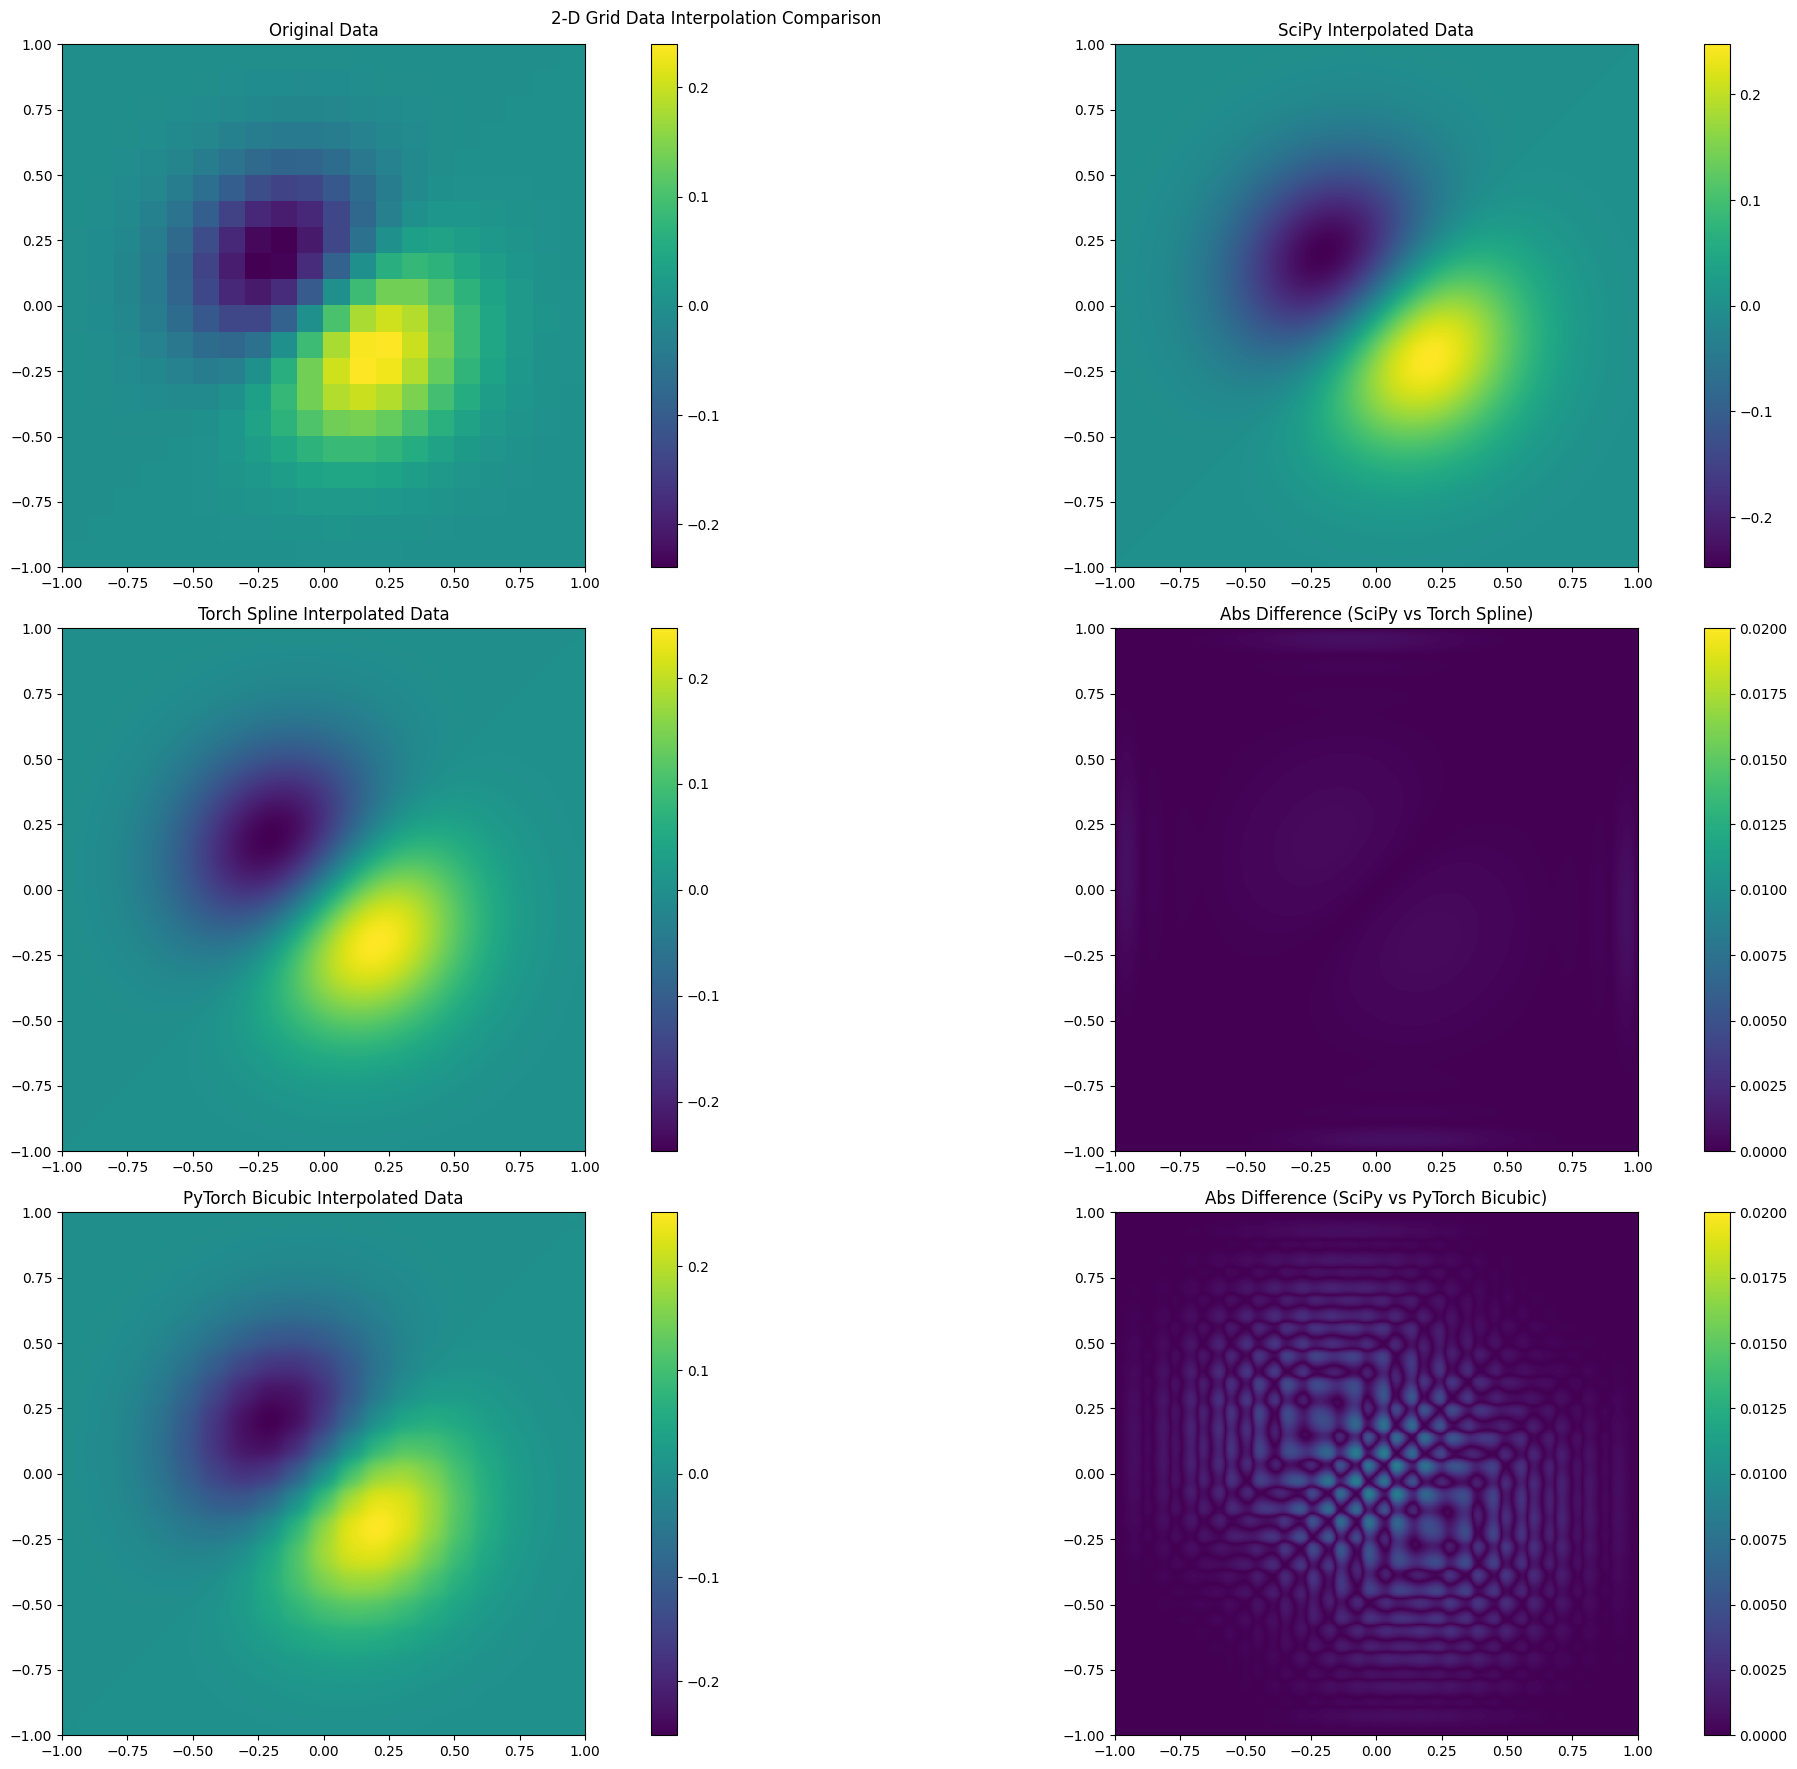

In [16]:
# Plotting the results
plt.figure(figsize=(24, 18))

# Plot original data
plt.subplot(3, 2, 1)
im = plt.imshow(z, extent=(-1, 1, -1, 1))
plt.colorbar(im)
plt.title('Original Data')

# Interpolate onto a new grid using SciPy for comparison
f = RectBivariateSpline(x, y, z)
znew_scipy = f(x_eval.numpy(), y_eval.numpy())

# Plot SciPy interpolated data
plt.subplot(3, 2, 2)
im = plt.imshow(znew_scipy, extent=(-1, 1, -1, 1))
plt.colorbar(im)
plt.title('SciPy Interpolated Data')

# Plot Torch spline interpolated data
plt.subplot(3, 2, 3)
im = plt.imshow(Z_new_torch.detach().numpy(), extent=(-1, 1, -1, 1))
plt.colorbar(im)
plt.title('Torch Spline Interpolated Data')


# Calculate the absolute differences
abs_diff_torch = np.abs(znew_scipy - Z_new_torch.detach().numpy())

# Plot the absolute difference between SciPy and Torch spline interpolations
plt.subplot(3, 2, 4)
im = plt.imshow(abs_diff_torch, extent=(-1, 1, -1, 1), vmin=0, vmax=0.02)
plt.colorbar(im)
plt.title('Abs Difference (SciPy vs Torch Spline)')

# Perform bicubic interpolation using PyTorch

z_torch_unsqueeze = z.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
znew_bicubic_torch = F.interpolate(z_torch_unsqueeze, size=(400, 400), mode='bicubic', align_corners=True)
znew_bicubic_torch = znew_bicubic_torch.squeeze(0).squeeze(0)  # Remove batch and channel dimensions

# Plot PyTorch bicubic interpolated data
plt.subplot(3, 2, 5)
im = plt.imshow(znew_bicubic_torch.detach().numpy(), extent=(-1, 1, -1, 1))

plt.colorbar(im)
plt.title('PyTorch Bicubic Interpolated Data')

# Calculate the absolute differences
abs_diff_bicubic = np.abs(znew_scipy - znew_bicubic_torch.detach().numpy())

# Plot the absolute difference between SciPy and PyTorch bicubic interpolations
plt.subplot(3, 2, 6)

im = plt.imshow(abs_diff_bicubic, extent=(-1, 1, -1, 1), vmin=0, vmax=0.02)
plt.colorbar(im)
plt.title('Abs Difference (SciPy vs PyTorch Bicubic)')

plt.suptitle('2-D Grid Data Interpolation Comparison')
plt.tight_layout()
plt.show()

## GWs Qplots interpolation

In this section we apply both the scipy's and the custom implemented torch interpolation methods to Spectrograms.
In particular, we test whether their integration with:
- https://github.com/ML4GW/ml4gw/blob/dev/ml4gw/transforms/qtransform.py#L275

Allows one to recover gwpy.q_transform() results:
- https://github.com/gwpy/gwpy/blob/ffffb8664c83e44fe349cda5d078bce0f40176f1/gwpy/signal/qtransform.py (for reference)

In [3]:
import numpy as np
import h5py as h5
from gwpy.timeseries import TimeSeries
import pandas as pd
from pathlib import Path
from gwpy.timeseries import TimeSeriesDict
#from lalframe.utils.frtools import get_channels
from os import listdir
from gwpy.signal import filter_design
from matplotlib import pyplot as plt
from matplotlib import gridspec
from tqdm import tqdm
import time
import json
import os
import ERF
import math

In [86]:
import importlib
import sys
from qptransformlinear import *

# Reload the module
importlib.reload(sys.modules['qptransformlinear'])

<module 'qptransformlinear' from 'C:\\Users\\loren\\qptransformlinear.py'>

In [84]:
import importlib
import sys
from torch_spline_interpolation import *

# Reload the module
importlib.reload(sys.modules['torch_spline_interpolation'])

<module 'torch_spline_interpolation' from 'C:\\Users\\loren\\torch_spline_interpolation.py'>

In [106]:
import importlib
import sys
from torch_smoothing_spline_interpolation import *

# Reload the module
importlib.reload(sys.modules['torch_smoothing_spline_interpolation'])

<module 'torch_smoothing_spline_interpolation' from 'C:\\Users\\loren\\torch_smoothing_spline_interpolation.py'>

Choose data to use, either Virgo data from local path or Ligo data from GWOSC. Feel free to experiment with different data.

#### Virgo data (from local path)

In [10]:
# change path to your local folder
file='DdncGnx3ph.h5'
event_id='DdncGnx3ph'
fout=h5.File(file)
strain=fout[event_id]['V1:Hrec_hoft_16384Hz']

#to inspect the file and read aux_channels:
#all_channels=list(fout[event_id])
#all_channels 

sample_rate = 500.0
duration=6

t0=strain.attrs['t0']
print(t0)

tms_strain=TimeSeries(strain, dt=1/strain.attrs['sample_rate'],t0=t0)
tms_strain = tms_strain.resample(sample_rate)
tms_strain=tms_strain.whiten()

#event=tms_strain
event = tms_strain.crop(t0+(16-duration)/2,t0+(16+duration)/2)
print(event)

1241762914.0
TimeSeries([-1.34473965, -3.76462878,  0.22659402, ...,
             2.22083019,  1.4107389 , -1.03851799]
           unit: dimensionless,
           t0: 1241762919.0 s,
           dt: 0.002 s,
           name: None,
           channel: None)


#### Ligo data (open access)

In [ ]:
sample_rate = 500.0
duration = 6

gps = 1239082262
data = TimeSeries.fetch_open_data('H1', gps-8, gps+8)
data = data.resample(sample_rate)
data = data.whiten()
event = data.crop(gps-duration/2, gps+duration/2)
print(event)

#### 

In [70]:
def compute_transforms(event, q=12, frange=(5, 100), sample_rate=500.0, qrange=[4, 64], num_t_bins=1000, fres=0.5,plot=False):
    """
    Compute various types of Q-transforms using both GWpy and PyTorch and visualize the results.

    Inputs:
    - event (TimeSeries): Input time series data.
    - q (float): Q-value for the Q-transform. Default vaule is 12
    - frange (tuple, optional): Frequency range for the Q-transform. Default is (5, 100).
    - sample_rate (float, optional): Sampling rate of the input data. Default is 500.0 Hz.
    - qrange (list, optional): Range of Q-values for the Q-scan. Default is [4, 64].
    - num_t_bins (int, optional): Number of time bins for the Q-transform. Default is 1000.
    - fres (float, optional): Frequency resolution for the Q-transform. Default is 0.5.

    Outputs:
    - gwpy_transform (Spectrogram): GWpy Q-transform with single Q-value.
    - transformed (Tensor): Torch Q-transform with single Q-value.
    - gwpy_transform_multiq (Spectrogram): GWpy Q-transform with multiple Q-values.
    - qtransform_multiq (Tensor): Torch Q-transform with multiple Q-values.

    """
    duration = event.duration.value
    tres = duration / num_t_bins
    num_f_bins = int((frange[1] - frange[0]) / fres)
    f_range = [frange[0], frange[1]]

    # Empty cache
    try:
        torch.cuda.empty_cache()
        print('Cache emptied')
    except:
        pass

    # Compute single Q GWpy Q-transform
    gwpy_transform = event.q_transform(qrange=[q, q], tres=tres, fres=fres, logf=False, whiten=False, frange=frange)

    # Compute multi-Q GWpy Q-transform
    gwpy_transform_multiq = event.q_transform(qrange=[4, 64], tres=tres, fres=fres, logf=False, whiten=False, frange=frange)

    # Compute default parameter choice GWpy Q-transform
    gwpy_transform_default = event.q_transform(whiten=False, frange=frange)

    # Compute Torch single Q Q-transform
    try:
        qtransform = SingleQTransformLinear(sample_rate=sample_rate, duration=duration, q=q, frange=frange).to(device)
    except:
        qtransform = SingleQTransform(sample_rate=sample_rate, duration=duration, q=q, frange=frange).to(device)

    transformed = qtransform(torch.Tensor(event.value).to(device), num_f_bins=num_f_bins, num_t_bins=num_t_bins)

    if plot:
        # Compute differences between Torch and GWpy Q-transforms
        abs_diff = abs(transformed.detach().cpu().numpy() - gwpy_transform.value).T
    
        # Plot Q-transforms
        fig, axes = plt.subplots(1, 3, figsize=(20, 7))
        im0 = axes[0].imshow(gwpy_transform.value.T, aspect="auto", origin="lower", vmin=0, vmax=25)
        axes[0].set_title("GWpy  single q")
        fig.colorbar(im0, ax=axes[0])
    
        im1 = axes[1].imshow(transformed.cpu().numpy().T, aspect="auto", origin="lower", vmin=0, vmax=25)
        axes[1].set_title("Torch single q")
        fig.colorbar(im1, ax=axes[1])
    
        im2 = axes[2].imshow(abs_diff, aspect="auto", origin="lower", vmin=0, vmax=25)
        axes[2].set_title("Abs Difference gwpy/ torch")
        fig.colorbar(im2, ax=axes[2])
    
    
        plt.show()
    
        #print out some stats
        print(f'SIZE GWPY: {gwpy_transform.value.T.shape}')
        print(f'SIZE GWPY default: {gwpy_transform_default.value.T.shape}')
        print(f'SIZE TORCH: {transformed.shape}')
        print(f'MAX VALUE OF GWPY: {np.max(gwpy_transform.value.T)}')
        print(f'MAX VALUE OF TORCH: {np.max(transformed.cpu().numpy())}')
        print(f'MEAN OF TORCH PLOT: {np.mean(transformed.cpu().numpy())}; STD: {np.std(transformed.cpu().numpy())}')
        print(f'MEAN OF GWPY PLOT: {np.mean(gwpy_transform.value.T)}; STD: {np.std(gwpy_transform.value.T)}')
        print(f'MEAN OF ABS DIFF PLOT: {np.mean(abs_diff)}; STD: {np.std(abs_diff)} ')
        
        return gwpy_transform,transformed
    else:
        return gwpy_transform,transformed

In [12]:
q = 12 #5.65685424949238 #12
num_t_bins=200
fres = 0.25
frange=(10,100)
qrange=[12,12]

#### Interpolation 1D

Before running the following cell, make sure to uncomment 

print('Returning Qtiles!!')

return self.qtiles

in qptransformlinear.interpolate (line 188-189 [line number might have changed!])

This will make compute_transforms return the qtiles as computed by qptrasnformlinear.py with no interpolation at all

In [89]:
#Compute Qtiles
start=time.time() 
gwpy_transform,transformed=compute_transforms(event, q=q, frange=frange, sample_rate=sample_rate, qrange=qrange, num_t_bins=num_t_bins, fres=fres)
end=time.time()
print(f'Total time: {end-start}s')

Cache emptied
Returning Qtiles!!
Total time: 0.5757641792297363s


Interpolate along the time dimension using both scipy's InterpolatedUnivariateSpline and the torch based natural cubic spline implemented in torch_spline_interpolation.py

In [90]:
from scipy.interpolate import InterpolatedUnivariateSpline
resampled_torch=[]
resampled_scipy=[]
for i,row in enumerate(transformed):
    row=row.squeeze(0).squeeze(0)
    
    #Torch
    row_intorch=torch_y=spline_interpolate(row,200,s=0.001)

    #Scipy
    xrow = np.linspace(-1,1,row.shape[0])
    scint=InterpolatedUnivariateSpline(xrow,row.numpy())
    row_scint=scint(np.linspace(-1,1,200))
    
    resampled_torch.append(row_intorch)
    resampled_scipy.append(row_scint)

In [91]:
# Convert lists to tensor and np.array respectively
resampled_torch = torch.stack(resampled_torch, dim=-2)
resampled_scipy = np.stack(resampled_scipy, axis=-2)

In [92]:
print(resampled_torch.shape)

torch.Size([175, 200])


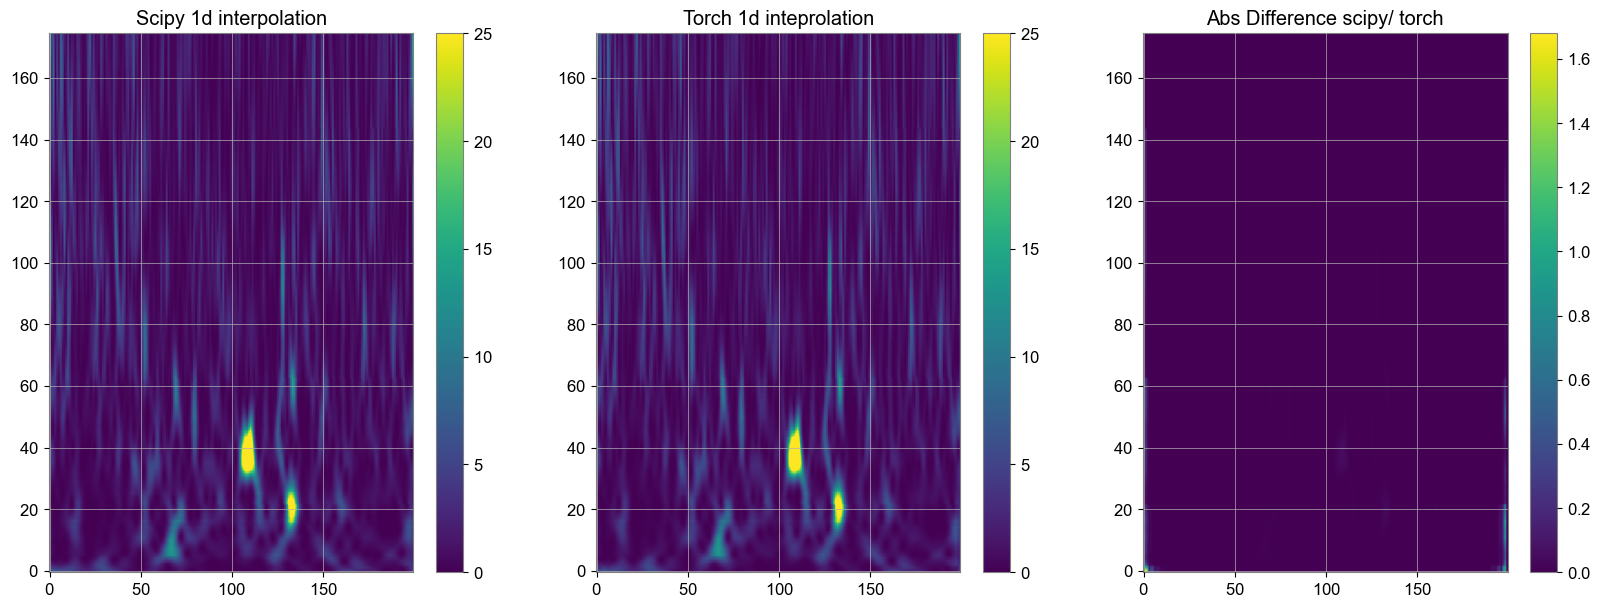

abs_diff.max()=1.6811938930553998


In [98]:
# Compute differences between Torch and Scipy interpolation of Q-transforms
abs_diff = abs(resampled_torch.numpy() - resampled_scipy)

# Plot Q-transforms
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
im0 = axes[0].imshow(resampled_scipy, aspect="auto", origin="lower", vmin=0, vmax=25)
axes[0].set_title("Scipy 1d interpolation")
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(resampled_torch.numpy(), aspect="auto", origin="lower", vmin=0, vmax=25)
axes[1].set_title("Torch 1d inteprolation")
fig.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(abs_diff, aspect="auto", origin="lower", vmin=0, vmax=1.68)
axes[2].set_title("Abs Difference scipy/ torch")
fig.colorbar(im2, ax=axes[2])


plt.show()
print(f'{abs_diff.max()=}')

##### From 1d to 2D

Interpolate along both the time and frequency dimension using scipy's RectBivariateSpline as well as the torch based bivariate cubic natural spline implemented in torch_spline_inteprolation.py

As a starting point, either the torch based or scipy 1d interpolation can be used

In [94]:
# Scipy
from scipy.interpolate import RectBivariateSpline

# Generate data
x = np.linspace(-1, 1, resampled_scipy.shape[0])
y = np.linspace(-1, 1, resampled_scipy.shape[1])
x_grid, y_grid = np.meshgrid(x, y)
z=resampled_scipy


# Create RectBivariateSpline
f = RectBivariateSpline(x, y, z)


# Interpolate onto a new grid
xnew = np.linspace(-1, 1, 360)
ynew = np.linspace(-1, 1, 200)
xnew_grid, ynew_grid = np.meshgrid(xnew, ynew)
znew_scipy = f(xnew, ynew)
print(znew_scipy.shape)

(360, 200)


In [103]:
#Torch

#choose either scipy's or torch 1d inteprolation as starting point. They should be the same (up to small numerical differences and border effects)
#Z=torch.from_numpy(resampled_scipy)
Z=resampled_torch

Z=Z.float()
num_t_bins=200
num_f_bins=360
znew_torch=spline_interpolate_2d(Z, num_f_bins, num_t_bins, logf=False, kx=3, ky=3, sx=0.001,sy=0.001)
print(znew_scipy.shape)

(360, 200)


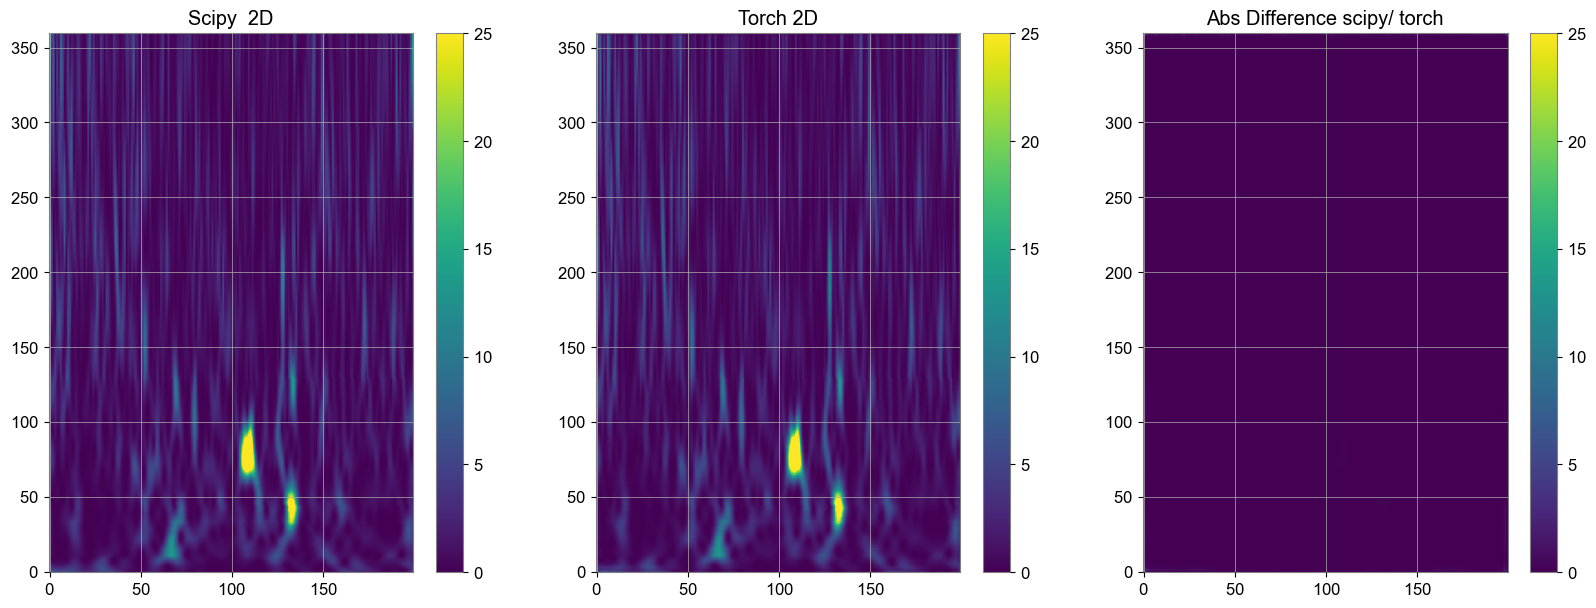

abs_diff.max()=3.883583298811013


In [104]:
# Compute differences between Torch and GWpy Q-transforms
abs_diff = abs(znew_torch.numpy() - znew_scipy)

# Plot Q-transforms
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
im0 = axes[0].imshow(znew_scipy, aspect="auto", origin="lower", vmin=0, vmax=25)
axes[0].set_title("Scipy  2D")
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(znew_torch.numpy(), aspect="auto", origin="lower", vmin=0, vmax=25)
axes[1].set_title("Torch 2D")
fig.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(abs_diff, aspect="auto", origin="lower", vmin=0, vmax=25)
axes[2].set_title("Abs Difference scipy/ torch")
fig.colorbar(im2, ax=axes[2])


plt.show()
print(f'{abs_diff.max()=}')

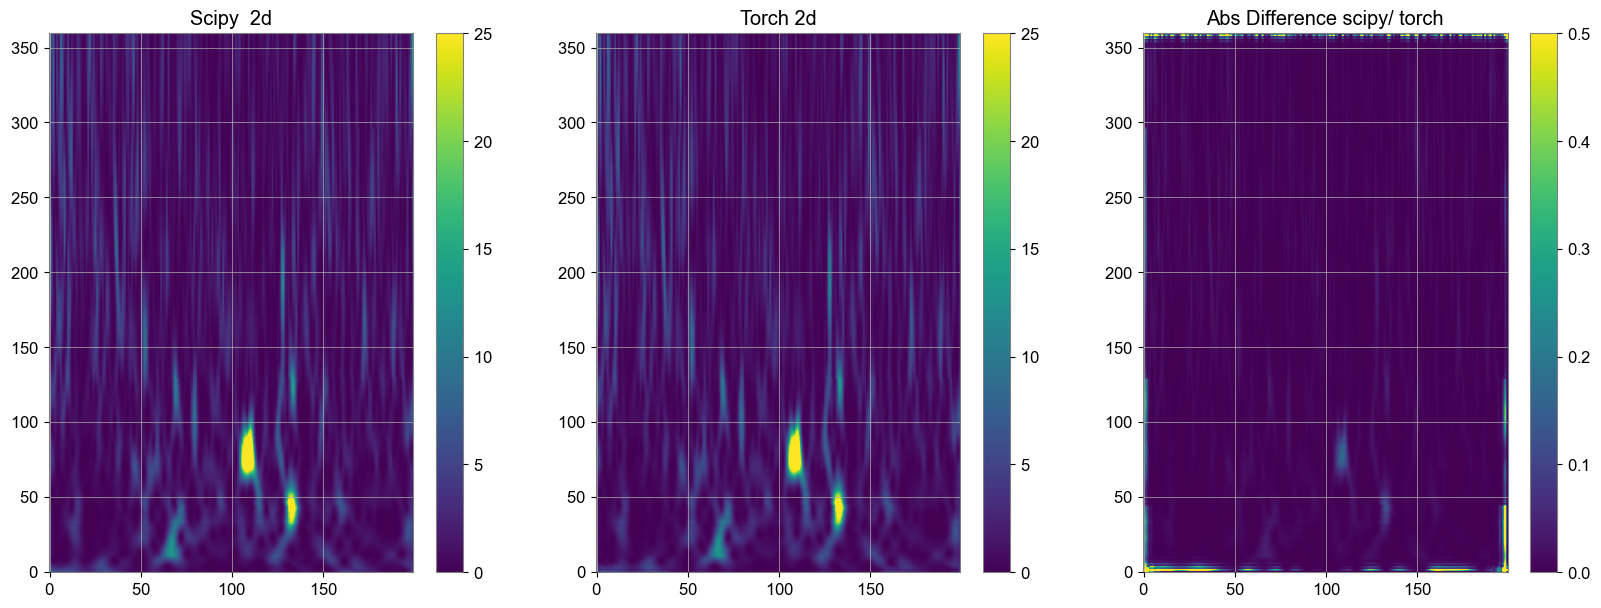

abs_diff.max()=3.883583298811013


In [105]:
# Compute differences between Torch and GWpy Q-transforms
abs_diff = abs(znew_torch.numpy() - znew_scipy)

# Plot Q-transforms
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
im0 = axes[0].imshow(znew_scipy, aspect="auto", origin="lower", vmin=0, vmax=25)
axes[0].set_title("Scipy  2d")
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(znew_torch.numpy(), aspect="auto", origin="lower", vmin=0, vmax=25)
axes[1].set_title("Torch 2d")
fig.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(abs_diff, aspect="auto", origin="lower", vmin=0, vmax=0.5)
axes[2].set_title("Abs Difference scipy/ torch")
fig.colorbar(im2, ax=axes[2])


plt.show()
print(f'{abs_diff.max()=}')

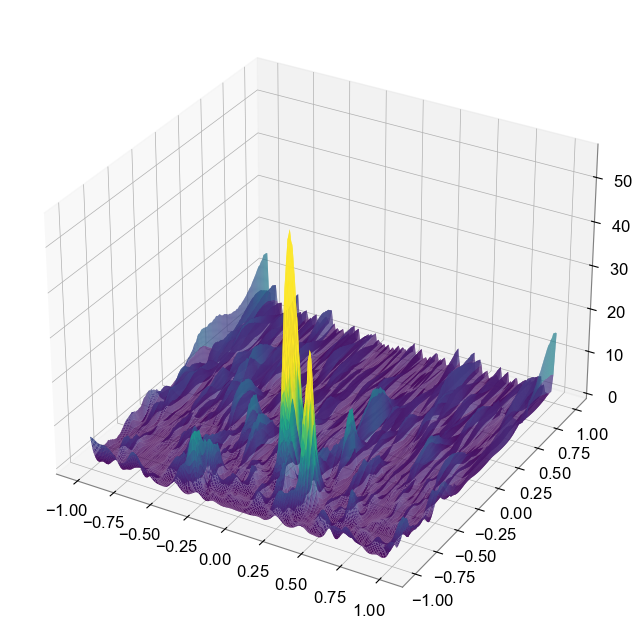

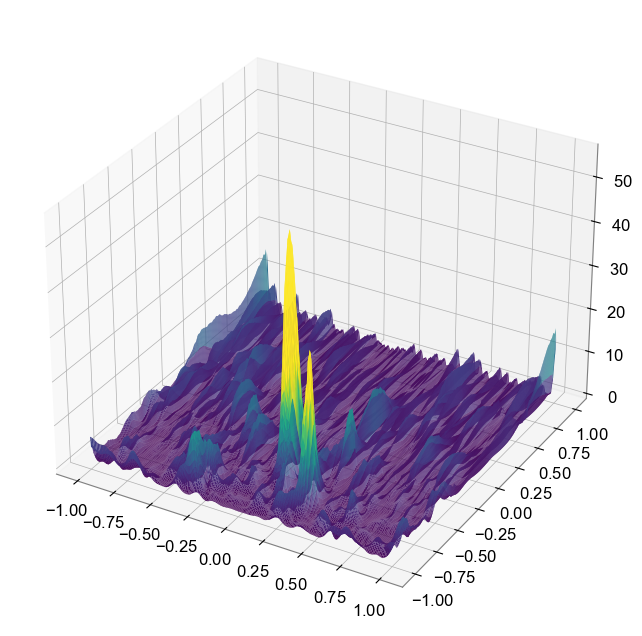

In [97]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_surface(values):

    times=np.linspace(-1,1,values.shape[0])
    frequencies=np.linspace(-1,1,values.shape[1])
    freq_mesh, time_mesh = np.meshgrid(frequencies, times)
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(freq_mesh, time_mesh, values, cmap='viridis', rstride=1, cstride=1, alpha=1, vmin=0, vmax=25)
    plt.show()

plot_3d_surface(znew_scipy)
plot_3d_surface(znew_torch.numpy())

The two 2d interpolation implementations seems to be practically the same up to small numerical errors and border effects

#### Interpolation 2D

Before running the following cell, make sure to comment 

#print('Returning Qtiles!!')

#return self.qtiles

in qptransformlinear.interpolate (line 188-189 [line number might have changed!])

This will make compute_transforms return gwpy and torch based qransforms. the torch based qtransform uses the interpolation steps shown in the section above

Cache emptied
Number of time bins: 200
x_bins=1024
nx_points=200
ny_points=175


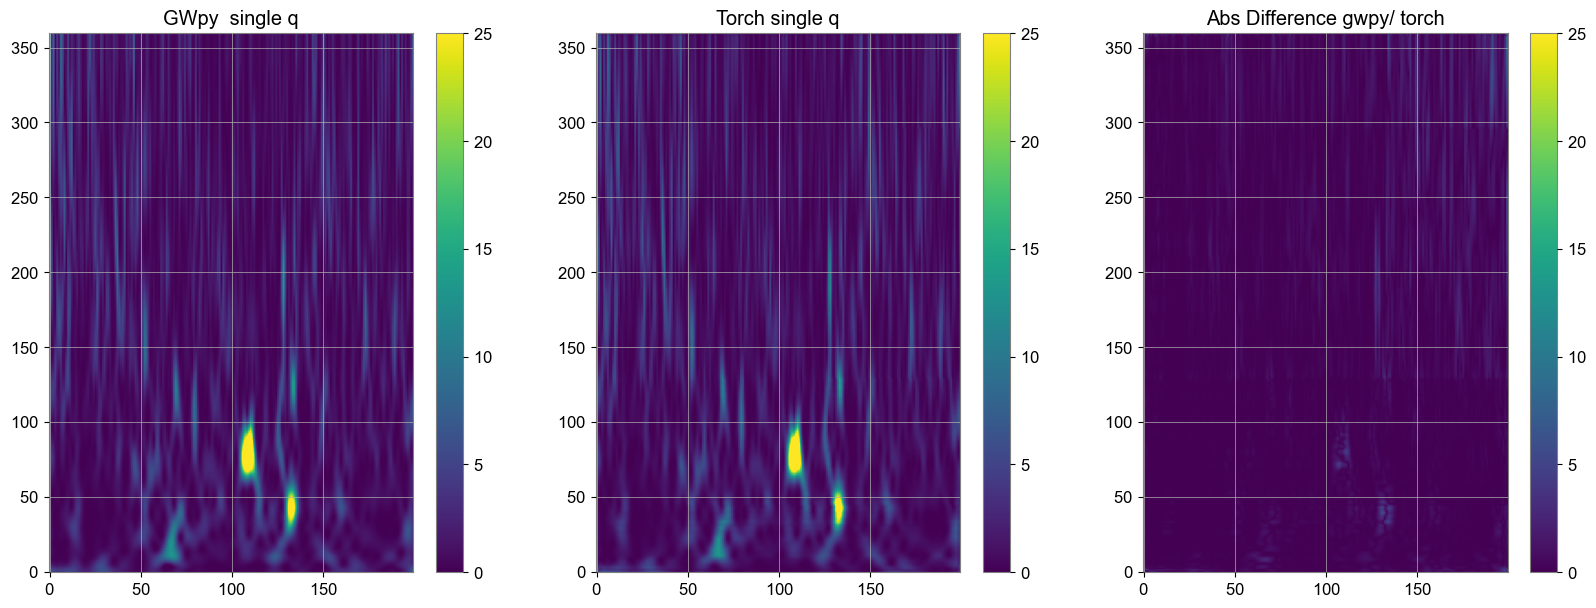

SIZE GWPY: (360, 200)
SIZE GWPY default: (180, 1000)
SIZE TORCH: torch.Size([200, 360])
MAX VALUE OF GWPY: 56.632728576660156
MAX VALUE OF TORCH: 56.05599594116211
MEAN OF TORCH PLOT: 1.6616058349609375; STD: 2.56423282623291
MEAN OF GWPY PLOT: 1.6566040515899658; STD: 2.548682451248169
MEAN OF ABS DIFF PLOT: 0.3752410113811493; STD: 0.5763233304023743 
Total time: 109.93017816543579s


In [71]:
start=time.time() 
gwpy_transform,transformed=compute_transforms(event, q=q, frange=frange, sample_rate=sample_rate, qrange=qrange, num_t_bins=num_t_bins, fres=fres,plot=True)
end=time.time()
print(f'Total time: {end-start}s')

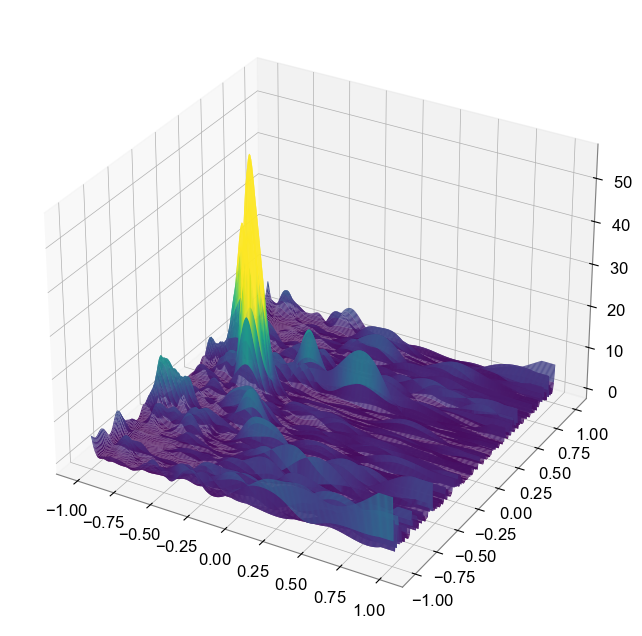

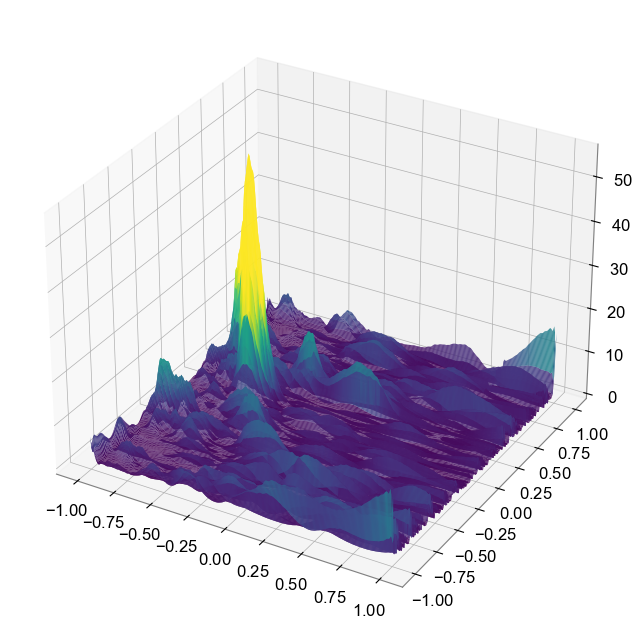

In [72]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_surface(values):

    times=np.linspace(-1,1,values.shape[0])
    frequencies=np.linspace(-1,1,values.shape[1])
    freq_mesh, time_mesh = np.meshgrid(frequencies, times)
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(freq_mesh, time_mesh, values, cmap='viridis', rstride=1, cstride=1, alpha=1, vmin=0, vmax=25)
    plt.show()

plot_3d_surface(gwpy_transform.value)
plot_3d_surface(transformed.numpy())

Upon inspecting:

- https://github.com/gwpy/gwpy/blob/ffffb8664c83e44fe349cda5d078bce0f40176f1/gwpy/signal/qtransform.py

(line 563 onwards), one would expect that the torch based 2d interpolation (either from 1d to 2d as above in the notebook, or using qptransformlinear.py) should be the same as gwpy's. But this is not the case as shown in the 3d and 2d plots above in this section. Therefore there are either differences in the way qtiles are computed or hidden parameters in scipy's interpolation methods, although the second option seems more unlikely.

The differences in the qtiles might be due to the code for the torch based qtransform not being up to date, check with:
- https://github.com/ML4GW/ml4gw/blob/dev/ml4gw/transforms/qtransform.py#L275

## Smoothing Spline (addressing border effects in 1d interpolation)

In this section we analyse different 1d interpolation methods using cubic splines.


In [255]:
import importlib
import sys
from torch_spline_interpolation import *

# Reload the module
importlib.reload(sys.modules['torch_spline_interpolation'])

<module 'torch_spline_interpolation' from 'C:\\Users\\loren\\torch_spline_interpolation.py'>

In [256]:
import importlib
import sys
from torch_smoothing_spline_interpolation import *

# Reload the module
importlib.reload(sys.modules['torch_smoothing_spline_interpolation'])

<module 'univariatesplineinterpolation' from 'C:\\Users\\loren\\univariatesplineinterpolation.py'>

torch_y_bicubic.shape=torch.Size([300])


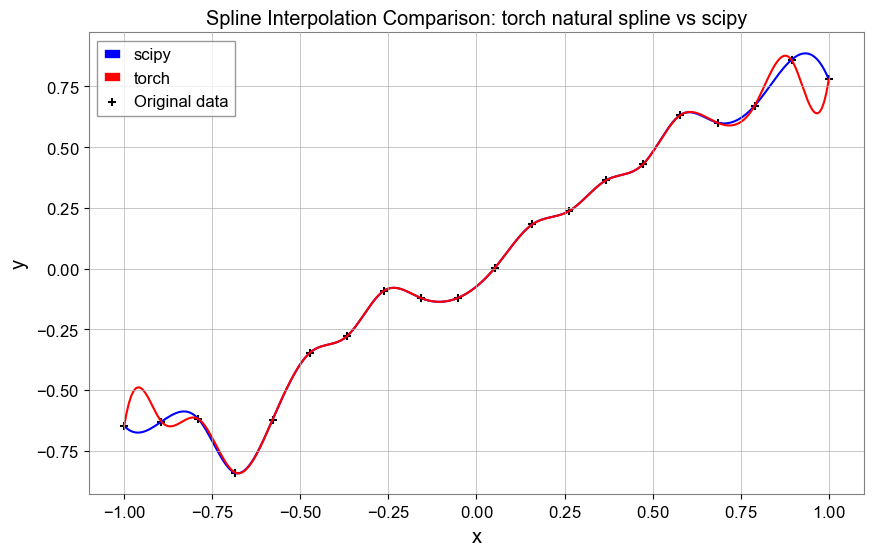

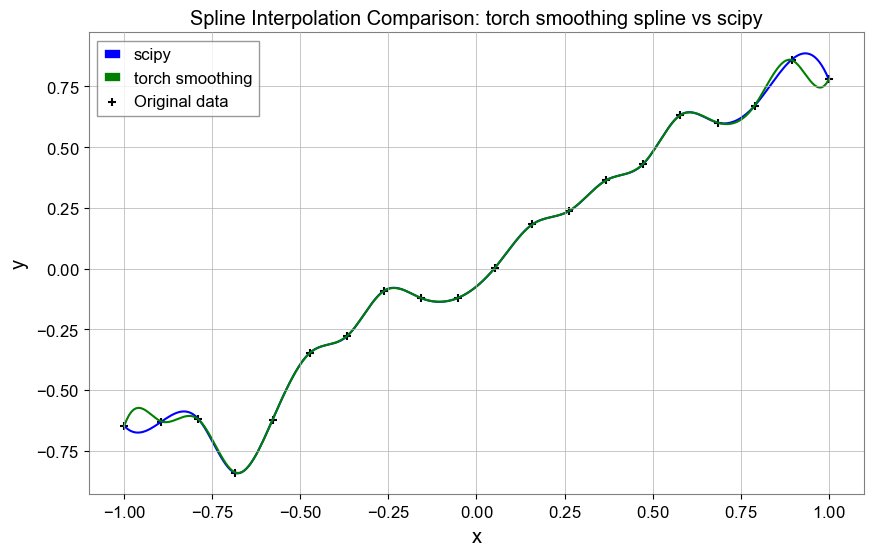

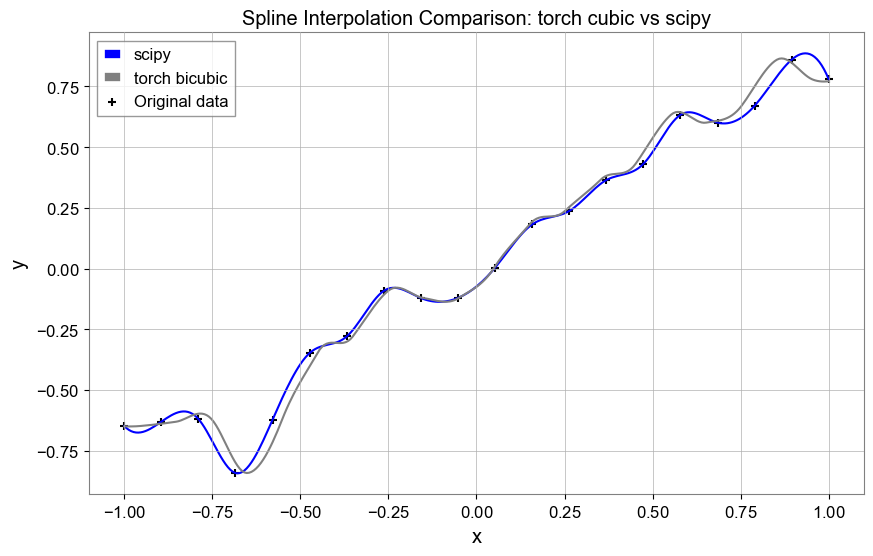

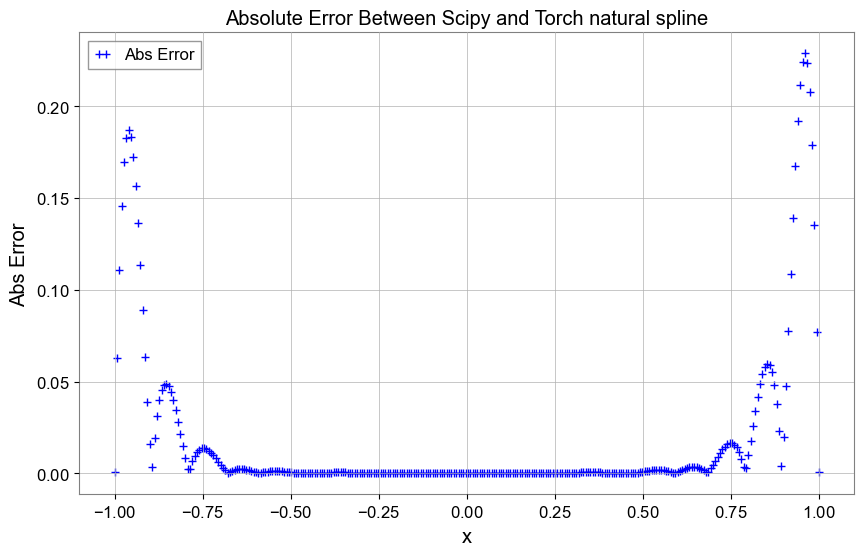

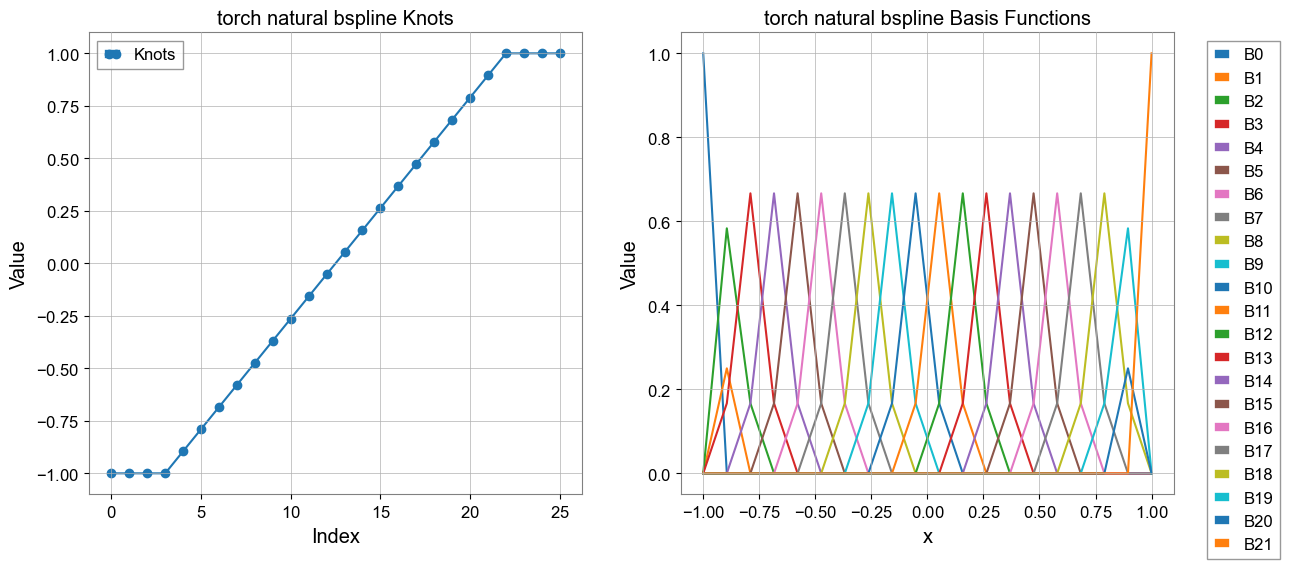

In [282]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline

num_t_bins=300

torch.manual_seed(42)

# Generate synthetic data
x = torch.linspace(-1, 1, 20)
y = torch.sin(x)+ 0.1 * torch.randn(x.size())


x_new = torch.linspace(-1, 1, num_t_bins)


# Spline interpolation with scipy
scipy_spline = InterpolatedUnivariateSpline(x, y, k=3)

scipy_y = scipy_spline(x_new)



# Perform interpolation with PyTorch
k = 3
t = generate_natural_knots(x_torch, k)
basis = bspline_basis_natural_torch(x_torch, k, t)
torch_y=spline_interpolate(y,num_t_bins,s=0.001)


#Perfomr inteprolation with smooth spline torch
# Smoothing parameter
p = 0.001
s=0.0001
# Perform the B-spline interpolation
tx, coef = bspline_interpolation(x, y, kx, p,max_iter=2000,tol=1e-10,s=s)
torch_y_smooth = evaluate_spline_torch(x_new, coef, tx, kx)

#Perform interpolation with torch bicubic
y_reshaped = y.view(1, 1, 20, 1)
torch_y_bicubic=F.interpolate(y_reshaped, size=(num_t_bins, 1), mode="bicubic")
torch_y_bicubic = torch_y_bicubic.squeeze()
print(f'{torch_y_bicubic.shape=}')


# Plot the results for comparison torch vs scipy
plt.figure(figsize=(10, 6))
plt.plot(x_new, scipy_y, label='scipy', color='blue')#, marker='o', linestyle='dashed')
plt.plot(x_new, torch_y.numpy(), label='torch', color='red')#, marker='x', linestyle='dotted')
plt.scatter(x, y, label='Original data', color='black',marker='+')
plt.legend()
plt.title('Spline Interpolation Comparison: torch natural spline vs scipy')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Plot the results for comparison smoothing torch vs scipy
plt.figure(figsize=(10, 6))
plt.plot(x_new, scipy_y, label='scipy', color='blue')#, marker='o', linestyle='dashed')
plt.plot(x_new, torch_y_smooth.numpy(), label='torch smoothing', color='green')#, marker='x', linestyle='dotted')
plt.scatter(x, y, label='Original data', color='black',marker='+')
plt.legend()
plt.title('Spline Interpolation Comparison: torch smoothing spline vs scipy')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Plot the results for comparison bicubic torch vs scipy
plt.figure(figsize=(10, 6))
plt.plot(x_new, scipy_y, label='scipy', color='blue')#, marker='o', linestyle='dashed')
plt.plot(x_new, torch_y_bicubic.numpy(), label='torch bicubic', color='grey')#, marker='x', linestyle='dotted')
plt.scatter(x, y, label='Original data', color='black',marker='+')
plt.legend()
plt.title('Spline Interpolation Comparison: torch cubic vs scipy')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Plot the absolute error
plt.figure(figsize=(10, 6))
abs_error = np.abs(scipy_y - torch_y.numpy())
plt.plot(x_new, abs_error, label='Abs Error', color='blue', marker='+', linestyle='none')
plt.legend()
plt.title('Absolute Error Between Scipy and Torch natural spline')
plt.xlabel('x')
plt.ylabel('Abs Error')
plt.show()

# Plot the knots and basis functions
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(t.numpy(), label='Knots', marker='o')
plt.legend()
plt.title('torch natural bspline Knots')
plt.xlabel('Index')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
for i in range(basis.shape[1]):
    plt.plot(x, basis[:, i], label=f'B{i}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('torch natural bspline Basis Functions')
plt.xlabel('x')
plt.ylabel('Value')

plt.show()


Both torch implementation display border effects in correspondence of the datapoints where the first and last pairs of basis spline funcitons are non zero. These effects might be caused by how boundary conditions are implemented, how bspline basis functions are computed, or by non optimal values of smoothing parameters. This remains unclear, as it is not possible to access scipy's Bspline basis functions without modifying the underlying fortran code:
- https://www.netlib.org/dierckx/fpcurf.f
- https://www.netlib.org/dierckx/fpadpo.f
- https://www.netlib.org/dierckx/fpbspl.f

which requires a lot of care. The way the fortran subroutines are called from the python package can be found at:
- https://github.com/scipy/scipy/blob/v1.13.1/scipy/interpolate/_fitpack2.py#L643-L742